# Homework 04: Building CNNs for Image Classification

## Due: Midnight on February 15 (with 2-hour grace period) and worth 85 points

In this assignment, you will take your first steps into designing and training convolutional neural networks (CNNs) for image classification. Starting from a simple baseline, you will experiment with modifications that reflect the kinds of design choices practitioners face every day. Along the way, you’ll see how architecture, hyperparameters, normalization, pooling strategies, and learning rate schedules can each shape a model’s performance.

The problems are organized to build on each other:

1. **Hyperparameters:** Begin with a baseline CNN and try variations in learning rate, layer width, depth, and dropout.
2. **Batch Normalization:** Add normalization after convolutional layers to stabilize training and speed convergence.
3. **Global Average Pooling:** Replace the flatten-and-dense head with a modern pooling layer, reducing parameters and improving generalization.
4. **ReduceLROnPlateau:** Explore a widely used learning rate scheduler that adapts when validation progress slows.
5. **Very Deep CNN:** Finally, run a VGG-16–style model to observe how deeper networks behave compared to smaller ones.

By the end of this homework, you will have hands-on experience with both classical and modern CNN design strategies, a sense of how different components affect learning, and a toolkit of techniques that will serve you in future image processing projects.

There are 10 graded questions, worth 8 points each, with 5 points free if you complete all of the graded questions in the homework.


## 1. Setup and Data Loading


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os,time,random,kagglehub

import tensorflow as tf
from tensorflow.keras import layers, Input, models, callbacks, regularizers,initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,MaxPooling2D,Conv2D,SeparableConv2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization

from sklearn.model_selection import train_test_split

# utility code

# -------------------------
# Reproducibility settings
# -------------------------

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [2]:

def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Testing and training sets already defined, accessed here as global variables

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Training and testing sets already defined, accessed here as global variables

In [3]:
# Uses globals: train_ds, val_ds, test_ds

def train_and_test(model,
                   epochs        = 500,
                   lr_schedule   = 1e-3,
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                # kept for API compatibility; ignored if datasets are batched
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")

    # Choose optimizer
    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    # Compile
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=verbose
    )

    cbs = ([early_stop] if use_early_stopping else []) + callbacks

    start = time.time()

    # Fit on tf.data datasets (already batched)
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=cbs,
        verbose=verbose
    )

    # Determine best validation accuracy
    if use_early_stopping and hasattr(early_stop, "best_epoch") and early_stop.best_epoch is not None:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = int(np.argmax(history.history['val_accuracy']))
        best_acc   = history.history['val_accuracy'][best_epoch]

    plot_learning_curves(history, title=title)

    # Evaluate on tf.data test set
    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history


### Load the Intel Image Classification Dataset  



In [4]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [5]:
import os
import numpy as np
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

def list_files_and_labels(directory, class_names=None, exts=(".jpg", ".jpeg", ".png")):
    """
    Returns:
      filepaths: np.array[str]
      labels:    np.array[int32]
      class_names_used: list[str] in deterministic order
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # keep only classes that exist in this directory, preserve given order
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    filepaths = []
    labels = []

    for cname in class_names:
        folder = os.path.join(directory, cname)
        for fname in sorted(os.listdir(folder)):  # deterministic within class
            if fname.lower().endswith(exts):
                filepaths.append(os.path.join(folder, fname))
                labels.append(class_to_idx[cname])

    return np.array(filepaths), np.array(labels, dtype=np.int32), class_names


def stratified_split_indices(y, val_frac=0.2, seed=42):
    """
    Deterministic stratified split over indices.
    Returns: train_idx, val_idx (np arrays)
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    n = len(y)

    train_idx_list = []
    val_idx_list = []

    classes = np.unique(y)
    for c in classes:
        idx = np.flatnonzero(y == c)
        rng.shuffle(idx)
        n_val = int(np.floor(len(idx) * val_frac))
        val_idx_list.append(idx[:n_val])
        train_idx_list.append(idx[n_val:])

    train_idx = np.concatenate(train_idx_list)
    val_idx = np.concatenate(val_idx_list)

    # Optional: shuffle each split deterministically so batches mix classes
    rng.shuffle(train_idx)
    rng.shuffle(val_idx)

    return train_idx, val_idx


def make_image_dataset(filepaths, labels, img_size=(150, 150), batch_size=32,
                       shuffle=False, seed=42, cache_to_disk=None):
    """
    Builds a tf.data.Dataset that loads images lazily from disk.
    - filepaths: np array of strings
    - labels:    np array of int32
    """
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    if shuffle:
        # shuffle file *references* (cheap), not image tensors
        ds = ds.shuffle(buffer_size=len(filepaths), seed=seed, reshuffle_each_iteration=True)

    def _load_and_preprocess(path, label):
        # read bytes -> decode -> resize -> float32 in [0,1]
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size, method="bilinear")
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    ds = ds.map(_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if cache_to_disk is not None:
        # Disk caching avoids RAM blowups; /tmp is fine in Colab
        ds = ds.cache(cache_to_disk)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


# -------------------------
# Example usage for Intel dataset
# -------------------------

IMG_SIZE    = (150, 150)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE  = 32
VAL_FRAC    = 0.2
SEED        = random_seed  # use your existing seed

# 1) List train files/labels deterministically
train_files, train_labels, class_names = list_files_and_labels(train_dir)

num_classes = len(class_names)

# 2) Stratified deterministic split of *indices* (no images loaded)
train_idx, val_idx = stratified_split_indices(train_labels, val_frac=VAL_FRAC, seed=SEED)

# 3) Slice file lists
files_train = train_files[train_idx]
y_train     = train_labels[train_idx]
files_val   = train_files[val_idx]
y_val       = train_labels[val_idx]

# 4) Build datasets (lazy image loading)
train_ds = make_image_dataset(files_train, y_train, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
                              cache_to_disk=None)  # or "/tmp/train_cache"

val_ds   = make_image_dataset(files_val, y_val, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=False,
                              cache_to_disk=None)  # or "/tmp/val_cache"

# 5) Test set: keep same class mapping as train
test_files, test_labels, _ = list_files_and_labels(test_dir, class_names=class_names)
test_ds = make_image_dataset(test_files, test_labels, img_size=IMG_SIZE,
                             batch_size=BATCH_SIZE, shuffle=False,
                             cache_to_disk=None)




### Examine The Dataset

In [6]:

def show_counts_from_labels(name, labels, class_names):
    c = Counter(labels.tolist())
    counts = {class_names[k]: c.get(k, 0) for k in range(len(class_names))}
    print(f"{name} per-class counts:", counts)

print("class_names:", class_names)
print("train examples:", len(files_train), "val examples:", len(files_val), "test examples:", len(test_files))

show_counts_from_labels("train", y_train, class_names)
show_counts_from_labels("val",   y_val,   class_names)
show_counts_from_labels("test",  test_labels, class_names)


class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
train examples: 11230 val examples: 2804 test examples: 3000
train per-class counts: {'buildings': 1753, 'forest': 1817, 'glacier': 1924, 'mountain': 2010, 'sea': 1820, 'street': 1906}
val per-class counts: {'buildings': 438, 'forest': 454, 'glacier': 480, 'mountain': 502, 'sea': 454, 'street': 476}
test per-class counts: {'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


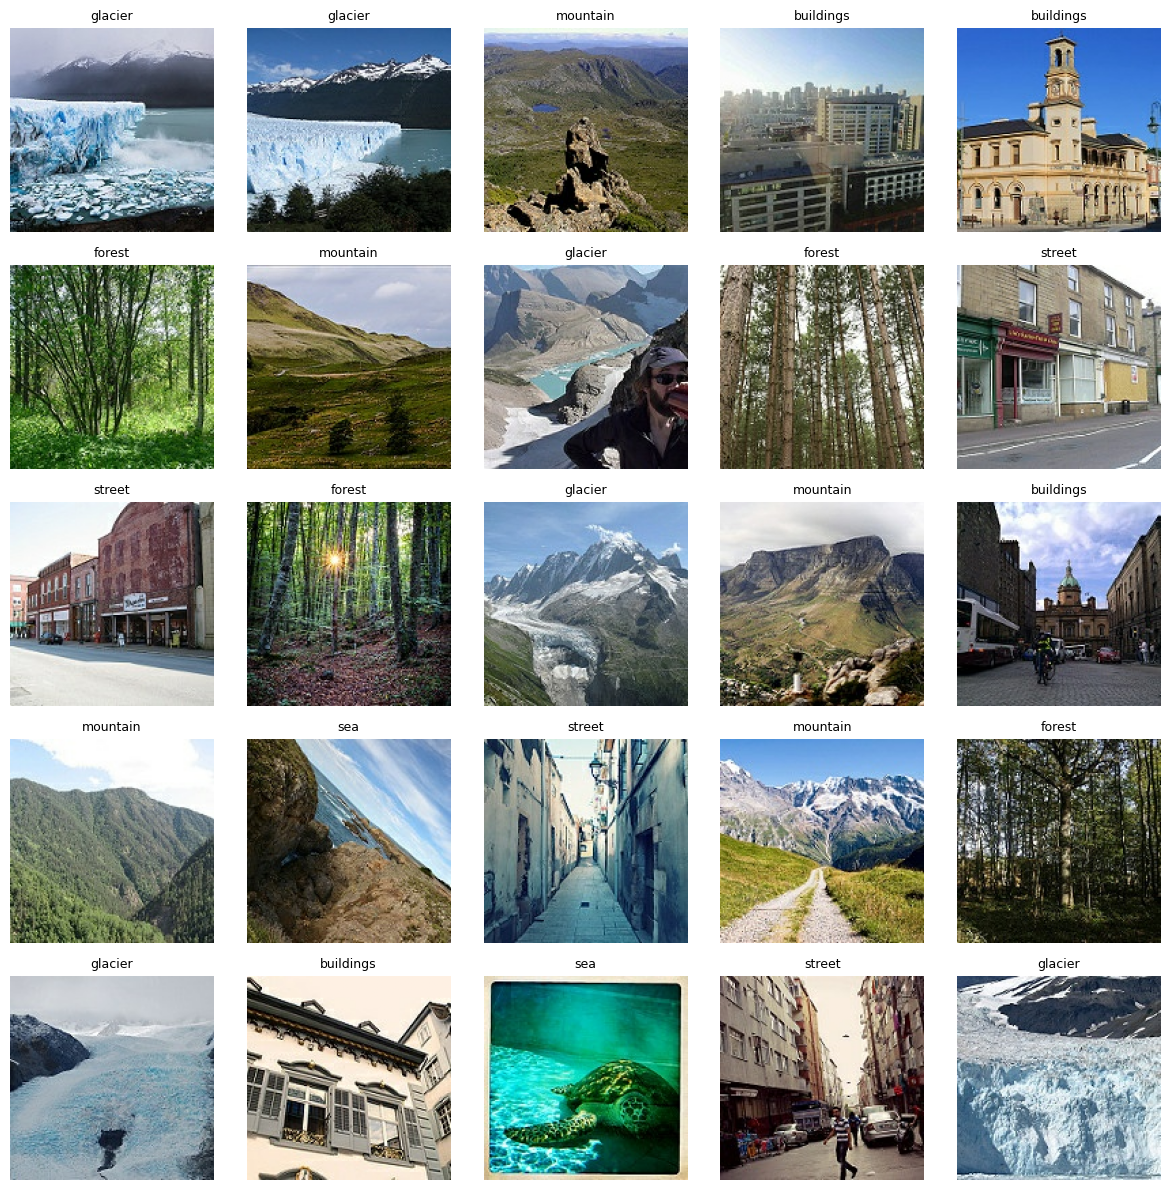

In [7]:
# Show 25 sample images

plt.figure(figsize=(12, 12))

# Take one batch from the dataset
images, labels = next(iter(train_ds))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[int(labels[i])], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prelude: Baseline CNN (reference model)

This is our **reference** network: two Conv→Pool blocks with channels **32 → 64**, followed by a **single hidden head** `Dense(64)`. We use **He** initialization for ReLU activations and include an **optional `Dropout(0.5)`** to illustrate regularization—comment it out to gauge its impact (ha, not really optional!).

Use this model as a stable yardstick while you run **ablations**: change **one knob at a time** (e.g., widen/deepen the conv blocks, adjust dropout rate, add batch norm, tweak the LR schedule) and compare results back to this baseline. Focus on **training vs. validation curves**, the **generalization gap**, and how dropout affects **val loss/accuracy** and how long it takes for Early Stopping to kick in.


**Warning:** Sometimes I get this, I think because it has exploding gradients; if you run it again, it generally disappears....

![Screenshot 2025-09-20 at 12.34.00 PM.png](attachment:c750862e-b0c8-405f-ae87-323064e42737.png)

In [8]:
# Make sure GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Confirm GPU is being used
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used for training.")
else:
    print("GPU is not available. Training will be performed on CPU, which may be slow.")

Num GPUs Available:  1
GPU is available and will be used for training.



Baseline Model



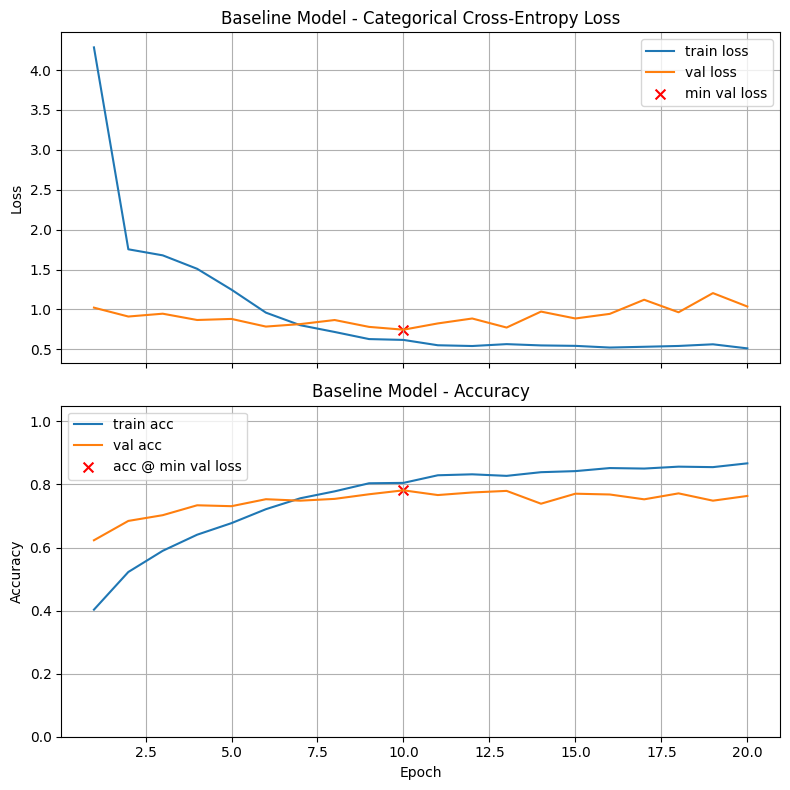

Final Training Loss:            0.5115
Final Training Accuracy:        0.8670
Final Validation Loss:          1.0364
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.7458 (Epoch 10)
Validation Accuracy @ Min Loss: 0.7814

Test Loss: 0.8300
Test Accuracy: 0.7797

Validation-Test Gap (accuracy): 0.001717

Execution Time: 00:02:40


In [ ]:
he = initializers.HeNormal()                                # best initializer for relu

model_baseline= models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

train_and_test(model_baseline,title=f"Baseline Model")


## Problem One: Exploring Basic Hyperparameters

**Task:**
Copy the baseline CNN model into the next cell and experiment with basic hyperparameter changes. Your goal is to see whether small tweaks can improve validation accuracy (and hopefully speed up convergence or produce smoother training curves). You must **pick 3 of the following tweaks** and investigate their effect:

**Tweaks to Try:**

1. Adjust the learning rate (default for Adam is `1e-3`).
2. Change the width of the `Conv2D` layers (e.g., 64 → 128).
3. Add an extra `Conv2D` layer (e.g., stack 32 → 64 → 128).
4. Change the width of the `Dense(64 ...)` layer.
5. Add L2 regularization to the `Dense(64 ...)` layer (see the head of the network in Problem 5 for inspiration).  
6. Modify the dropout rate.
   
Observe the effect of each of your 3 choices in isolation and answer the graded questions.

**Optional:**
Combine two or more changes to see if they work together to improve results (example: try L2 regularization and reduced dropout in the head, as in Problem 5).


**Pro Tip:** Give each experiment a descriptive title, such as "Problem 1 -- Tweak 1 -- lr: 0.0005" to keep track of your experiments (see last cell in the notebook).


Problem 1 -- Tweak 1 -- lr: 0.0005



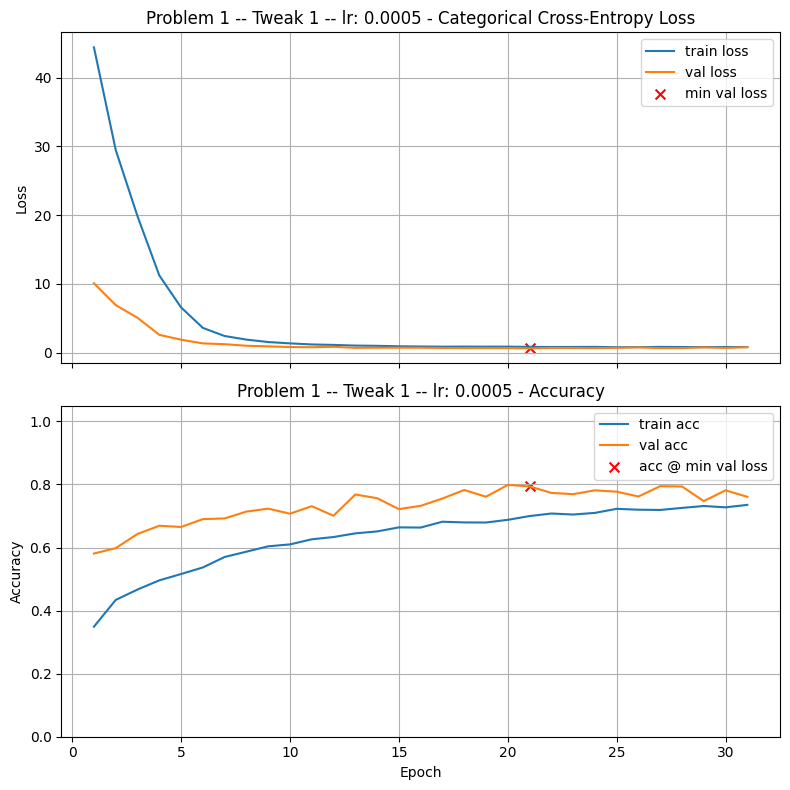

Final Training Loss:            0.7916
Final Training Accuracy:        0.7353
Final Validation Loss:          0.7777
Final Validation Accuracy:      0.7607
Minimum Validation Loss:        0.6038 (Epoch 21)
Validation Accuracy @ Min Loss: 0.7939

Test Loss: 0.6530
Test Accuracy: 0.7860

Validation-Test Gap (accuracy): 0.007866

Execution Time: 00:04:10

Problem 1 -- Tweak 2 -- widen conv layers



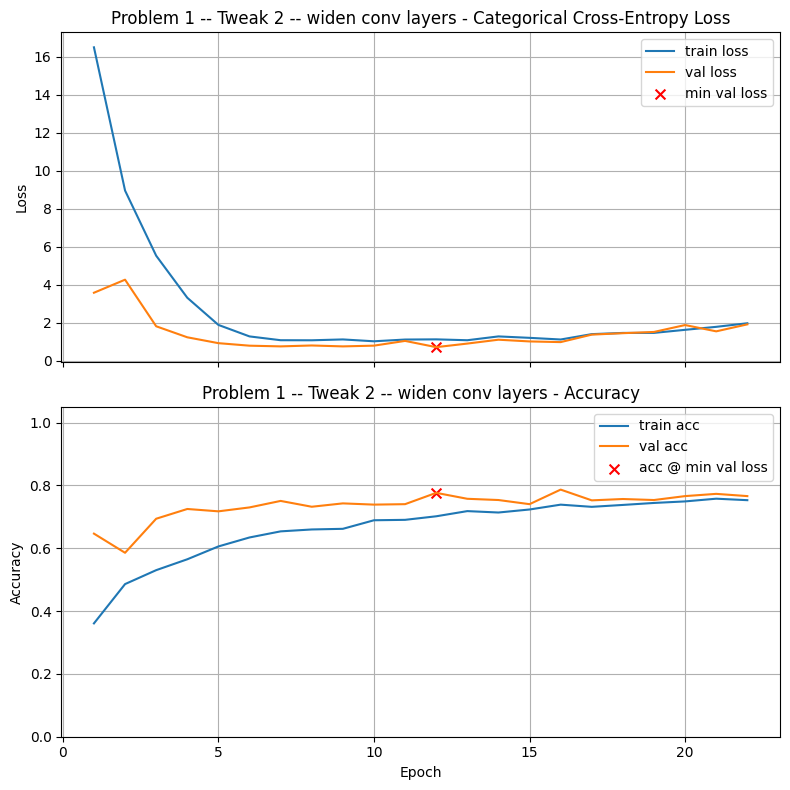

Final Training Loss:            1.9797
Final Training Accuracy:        0.7531
Final Validation Loss:          1.9217
Final Validation Accuracy:      0.7660
Minimum Validation Loss:        0.7227 (Epoch 12)
Validation Accuracy @ Min Loss: 0.7764

Test Loss: 0.7774
Test Accuracy: 0.7727

Validation-Test Gap (accuracy): 0.003724

Execution Time: 00:05:44

Problem 1 -- Tweak 3 -- extra block



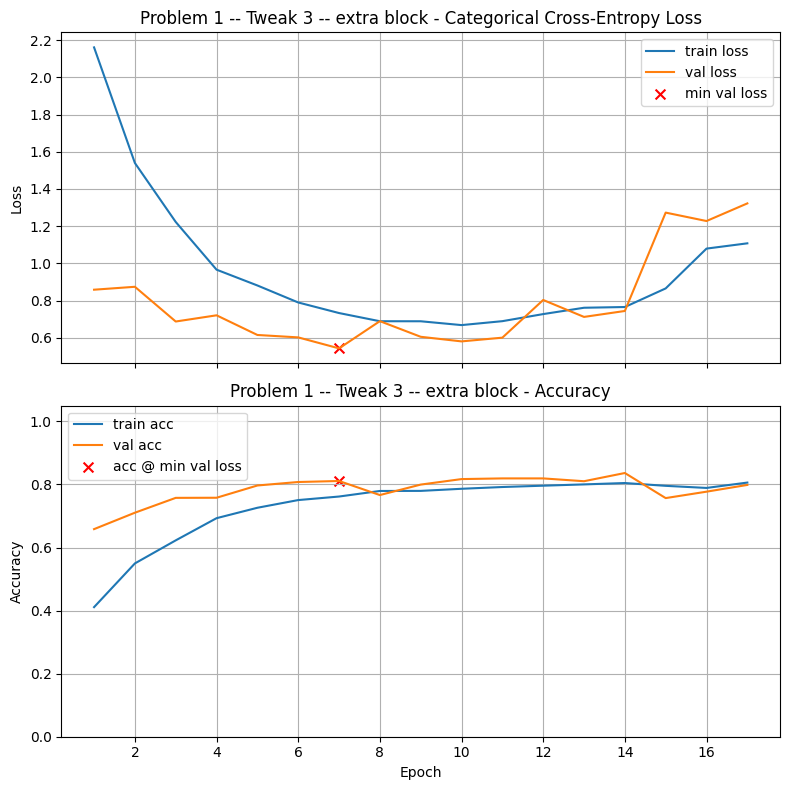

Final Training Loss:            1.1076
Final Training Accuracy:        0.8060
Final Validation Loss:          1.3225
Final Validation Accuracy:      0.7985
Minimum Validation Loss:        0.5424 (Epoch 7)
Validation Accuracy @ Min Loss: 0.8110

Test Loss: 0.5710
Test Accuracy: 0.8077

Validation-Test Gap (accuracy): 0.003318

Execution Time: 00:02:40

Problem 1 -- Tweak 4 -- wider dense 128



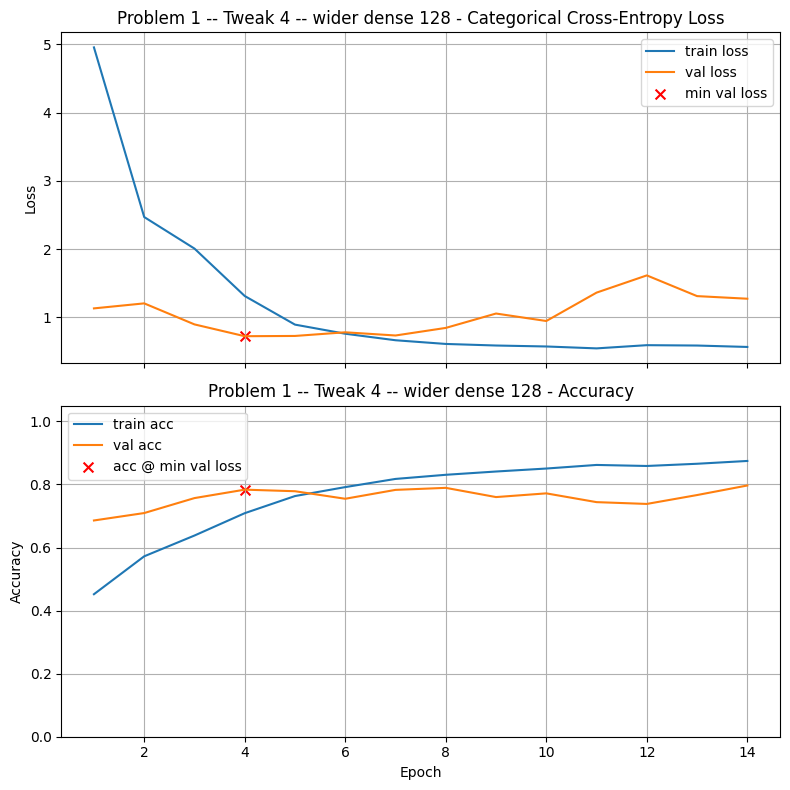

Final Training Loss:            0.5681
Final Training Accuracy:        0.8745
Final Validation Loss:          1.2747
Final Validation Accuracy:      0.7967
Minimum Validation Loss:        0.7254 (Epoch 4)
Validation Accuracy @ Min Loss: 0.7835

Test Loss: 0.8128
Test Accuracy: 0.7833

Validation-Test Gap (accuracy): 0.000190

Execution Time: 00:02:13

Problem 1 -- Tweak 5 -- L2 regularization



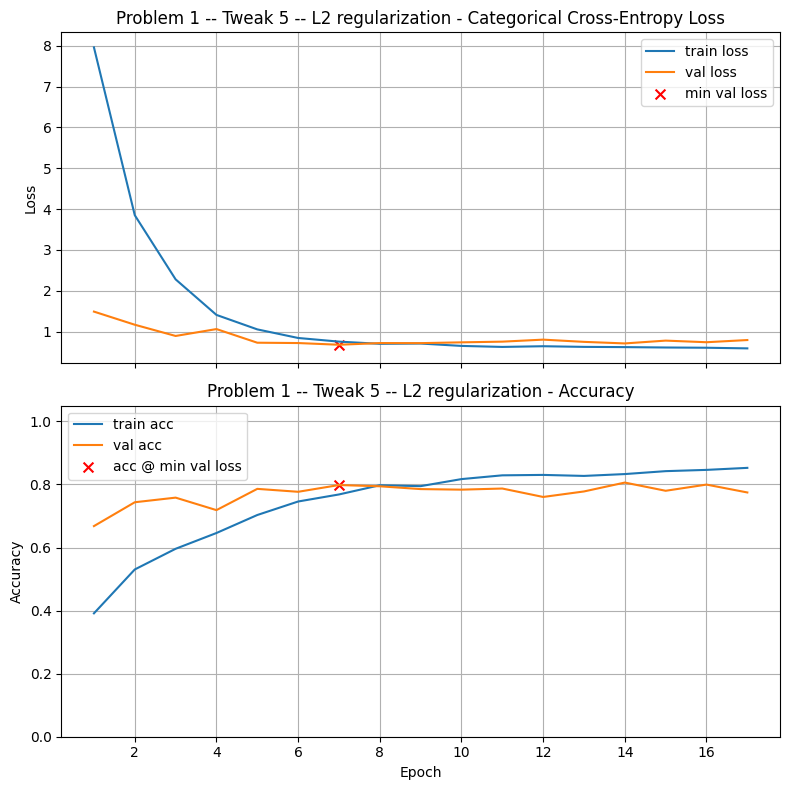

Final Training Loss:            0.5882
Final Training Accuracy:        0.8526
Final Validation Loss:          0.7924
Final Validation Accuracy:      0.7746
Minimum Validation Loss:        0.6772 (Epoch 7)
Validation Accuracy @ Min Loss: 0.7981

Test Loss: 0.7288
Test Accuracy: 0.7940

Validation-Test Gap (accuracy): 0.004146

Execution Time: 00:02:29

Problem 1 -- Tweak 6 -- less dropout 0.3



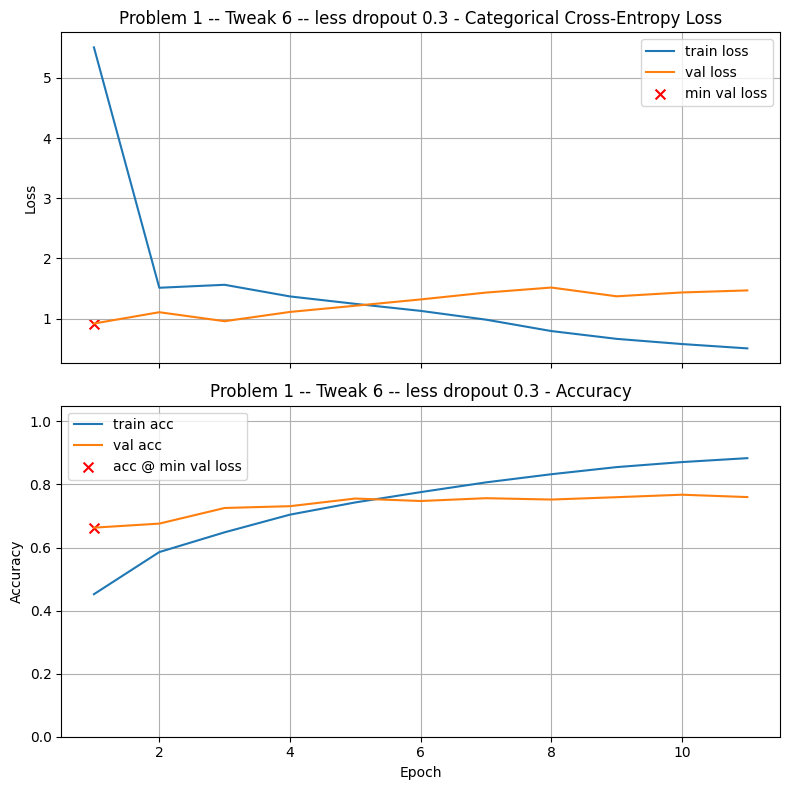

Final Training Loss:            0.5052
Final Training Accuracy:        0.8834
Final Validation Loss:          1.4687
Final Validation Accuracy:      0.7600
Minimum Validation Loss:        0.9182 (Epoch 1)
Validation Accuracy @ Min Loss: 0.6630

Test Loss: 0.9903
Test Accuracy: 0.6473

Validation-Test Gap (accuracy): 0.015648

Execution Time: 00:01:31


In [ ]:
# Your code here, add additional cells if you wish
he = initializers.HeNormal()                                # best initializer for relu

# Tweak 1: Adjust learning rate to 0.0005
model1_lr_adjust=models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model1_lr_adjust,title=f"Problem 1 -- Tweak 1 -- lr: 0.0005",
               lr_schedule=0.0005)

# Tweak 2: widen conv layers
model2_width_conv_adjust =models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model2_width_conv_adjust,title=f"Problem 1 -- Tweak 2 -- widen conv layers")

# Tweak 3: add extra conv block
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),  # extra block
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 1 -- Tweak 3 -- extra block")

# Tweak 4: widen dense layer
model4_wider_dense = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(128, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model4_wider_dense,title=f"Problem 1 -- Tweak 4 -- wider dense 128")

# Tweak 5: L2 regularization on dense layer
model5_l2 = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model5_l2,title=f"Problem 1 -- Tweak 5 -- L2 regularization")

# Tweak 6: less dropout
model6_dropout_change = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.3),  # less dropout
    Dense(num_classes, activation="softmax")
])
train_and_test(model6_dropout_change,title=f"Problem 1 -- Tweak 6 -- less dropout 0.3")

### Graded Questions

In [ ]:
# Set a1a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 3             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a}')


a1a = 3


In [ ]:
# Set a1b to the validation accuracy found by the choice specified in Question a1a.

a1b = 0.8110             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1b = {a1b:.4f}')

a1b = 0.8110


## Problem Two: Adding Batch Normalization

**Task:**
Take your best model from Problem One and add a `BatchNormalization()` layer immediately after each `Conv2D` layer. Batch normalization helps stabilize training and can improve convergence.

**Next Steps:**

* Train the model with batch normalization included after each `Conv2D` layer.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare the results to your earlier experiments and answer the graded questions.

**Optional:**
Try more than one hyperparameter change alongside batch normalization and see how they interact.




Problem 1 -- Tweak 1 -- lr: 0.0005 w/ batch norm



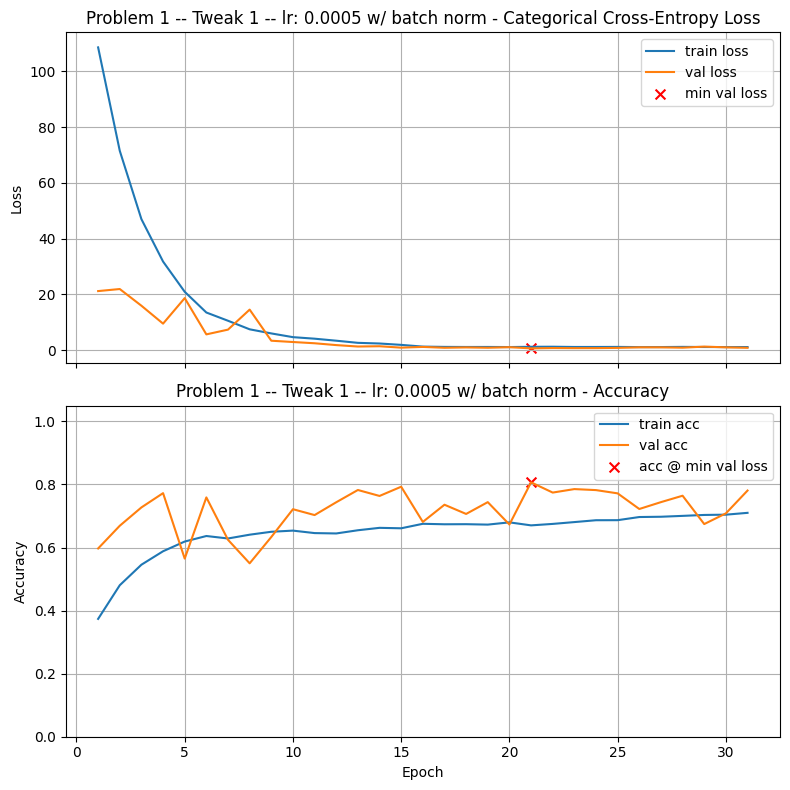

Final Training Loss:            1.0813
Final Training Accuracy:        0.7100
Final Validation Loss:          0.8093
Final Validation Accuracy:      0.7807
Minimum Validation Loss:        0.6018 (Epoch 21)
Validation Accuracy @ Min Loss: 0.8067

Test Loss: 0.6556
Test Accuracy: 0.8010

Validation-Test Gap (accuracy): 0.005705

Execution Time: 00:08:13

Problem 1 -- Tweak 2 -- widen conv layers w/ batch norm



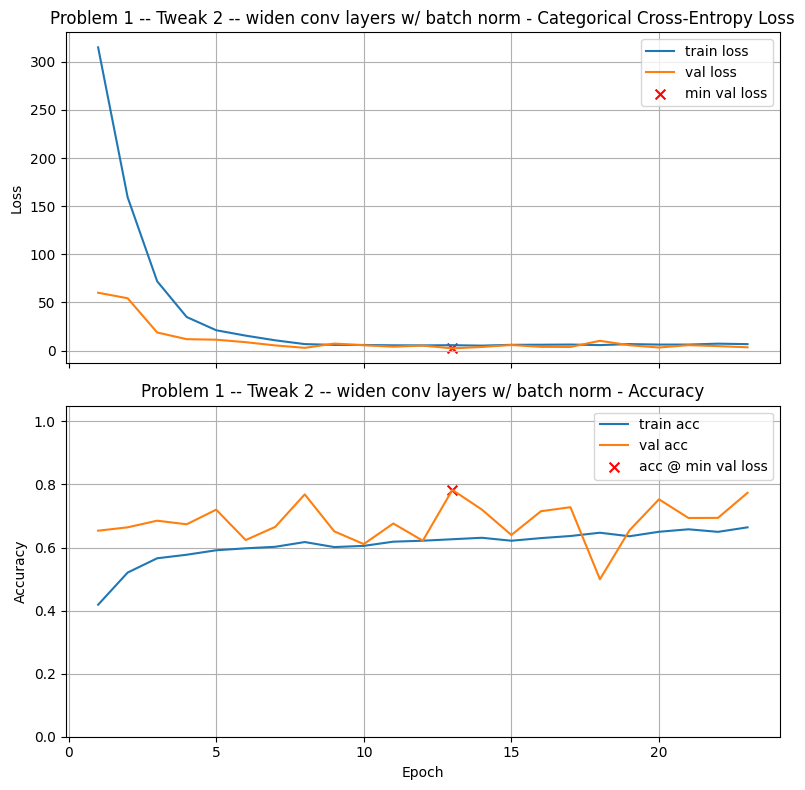

Final Training Loss:            6.6400
Final Training Accuracy:        0.6640
Final Validation Loss:          3.3500
Final Validation Accuracy:      0.7735
Minimum Validation Loss:        2.2241 (Epoch 13)
Validation Accuracy @ Min Loss: 0.7828

Test Loss: 2.4254
Test Accuracy: 0.7737

Validation-Test Gap (accuracy): 0.009144

Execution Time: 00:11:42

Problem 1 -- Tweak 3 -- extra block w/ batch norm



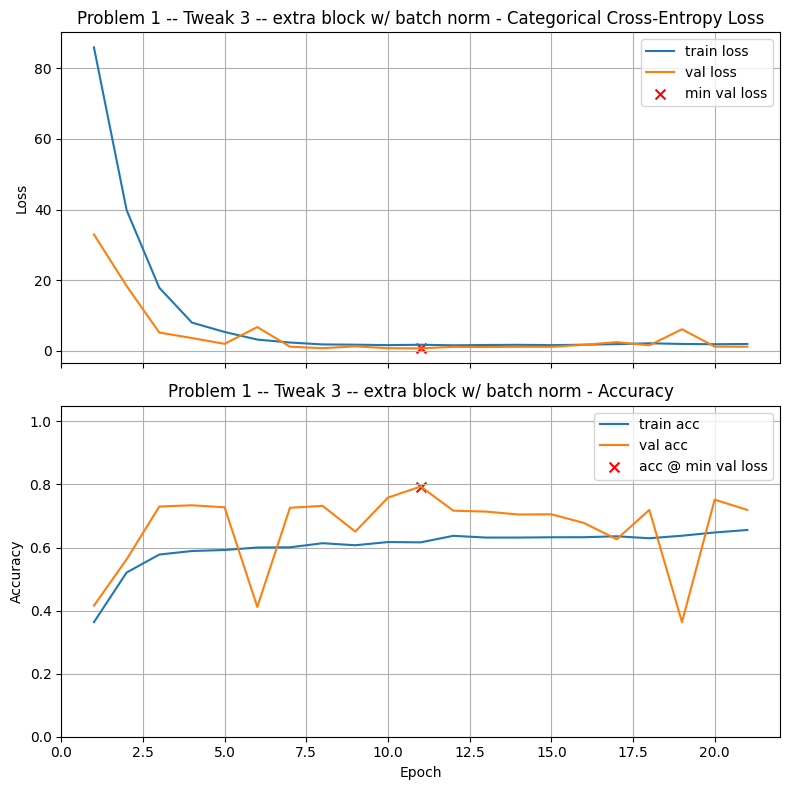

Final Training Loss:            1.9885
Final Training Accuracy:        0.6557
Final Validation Loss:          1.2109
Final Validation Accuracy:      0.7193
Minimum Validation Loss:        0.7379 (Epoch 11)
Validation Accuracy @ Min Loss: 0.7935

Test Loss: 0.7914
Test Accuracy: 0.7917

Validation-Test Gap (accuracy): 0.001843

Execution Time: 00:06:20

Problem 1 -- Tweak 4 -- wider dense 128 w/ batch norm



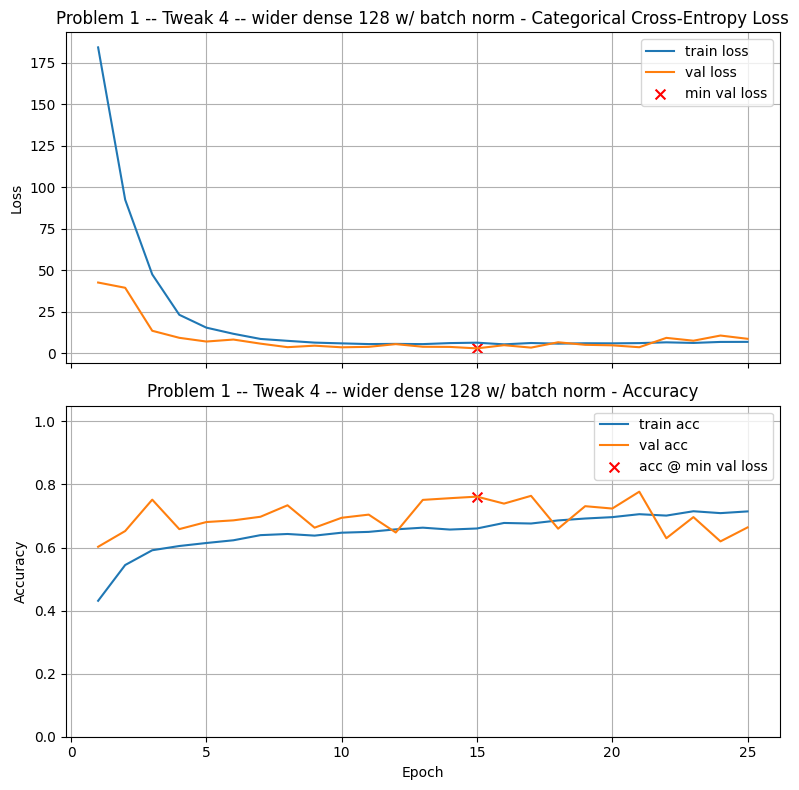

Final Training Loss:            6.9820
Final Training Accuracy:        0.7145
Final Validation Loss:          8.8294
Final Validation Accuracy:      0.6637
Minimum Validation Loss:        3.0629 (Epoch 15)
Validation Accuracy @ Min Loss: 0.7614

Test Loss: 3.4828
Test Accuracy: 0.7583

Validation-Test Gap (accuracy): 0.003079

Execution Time: 00:07:02

Problem 1 -- Tweak 5 -- L2 regularization w/ batch norm



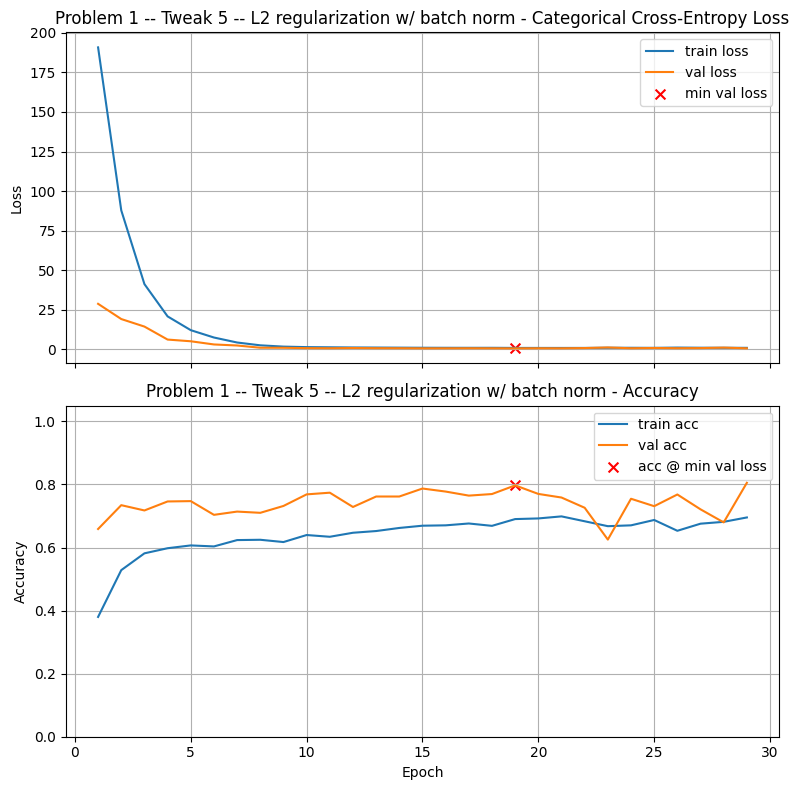

Final Training Loss:            0.9967
Final Training Accuracy:        0.6954
Final Validation Loss:          0.6948
Final Validation Accuracy:      0.8053
Minimum Validation Loss:        0.6606 (Epoch 19)
Validation Accuracy @ Min Loss: 0.7971

Test Loss: 0.6903
Test Accuracy: 0.7980

Validation-Test Gap (accuracy): 0.000924

Execution Time: 00:07:50

Problem 1 -- Tweak 6 -- less dropout 0.3 w/ batch norm



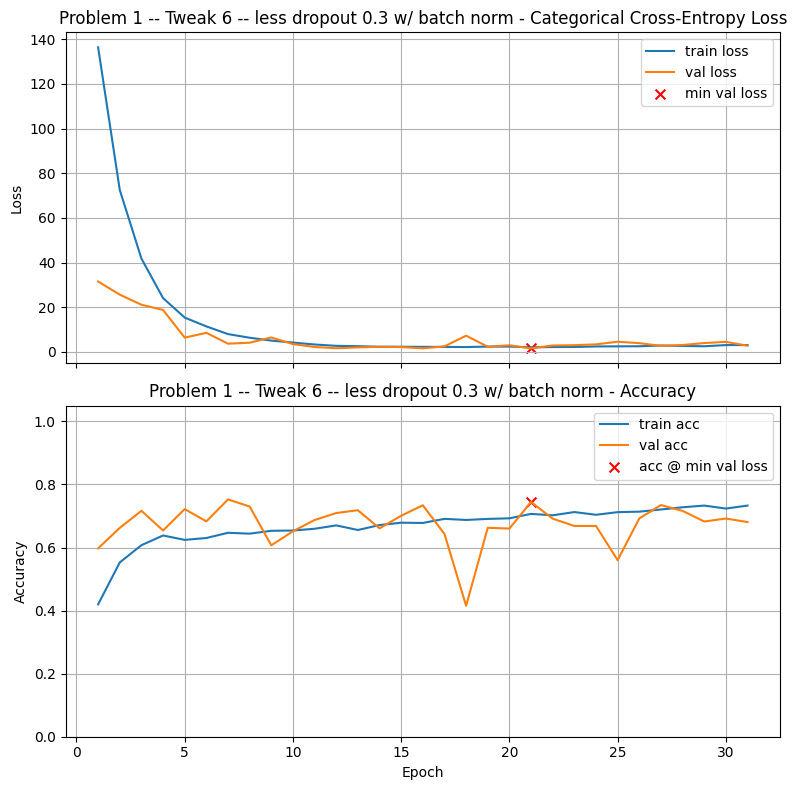

Final Training Loss:            3.0653
Final Training Accuracy:        0.7330
Final Validation Loss:          2.7560
Final Validation Accuracy:      0.6808
Minimum Validation Loss:        1.5666 (Epoch 21)
Validation Accuracy @ Min Loss: 0.7443

Test Loss: 1.6857
Test Accuracy: 0.7403

Validation-Test Gap (accuracy): 0.003961

Execution Time: 00:08:09


In [ ]:
# Your code here, add additional cells if you wish
from tensorflow.keras.layers import Activation

# Tweak 1: Adjust learning rate to 0.0005 w/ batch norm
model1_lr_adjust=models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model1_lr_adjust,title=f"Problem 1 -- Tweak 1 -- lr: 0.0005 w/ batch norm",
               lr_schedule=0.0005)

# Tweak 2: widen conv layers w/ batch norm
model2_width_conv_adjust =models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model2_width_conv_adjust,title=f"Problem 1 -- Tweak 2 -- widen conv layers w/ batch norm")

# Tweak 3: add extra conv block w/ batch norm
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),  # extra block
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 1 -- Tweak 3 -- extra block w/ batch norm")

# Tweak 4: widen dense layer w/ batch norm
model4_wider_dense = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Flatten(),
    Dense(128, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model4_wider_dense,title=f"Problem 1 -- Tweak 4 -- wider dense 128 w/ batch norm")

# Tweak 5: L2 regularization on dense layer w/ batch norm
model5_l2 = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model5_l2,title=f"Problem 1 -- Tweak 5 -- L2 regularization w/ batch norm")

# Tweak 6: less dropout w/ batch norm
model6_dropout_change = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Flatten(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.3),  # less dropout
    Dense(num_classes, activation="softmax")
])
train_and_test(model6_dropout_change,title=f"Problem 1 -- Tweak 6 -- less dropout 0.3 w/ batch norm")

### Graded Questions

In [ ]:
# Set a2a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 0             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a}')


a2a = 0


In [ ]:
# Set a2b to the validation accuracy found by the choice specified in Question a2a (your best model for this problem)

a2b = 0.8067             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.8067


## Problem Three: Global Average Pooling

As we saw in this week's Coding Video,
**Global Average Pooling** is a simple layer that replaces the `Flatten → Dense` part of a CNN (please review that part of the Coding Notebook, which contains a description of this important technique).

In practice, swapping `Flatten` for `GlobalAveragePooling2D` often improves stability and validation performance — definitely worth considering!


**Task:**
Modify your best model from Problems 1 & 2 to use a `GlobalAveragePooling2D()` layer instead of a flatten-and-dense block.

**Next Steps:**

* Replace the sequence between the last `Conv2D` and output layers, for example:

     
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(64, activation='relu', kernel_initializer=initializers.HeNormal()),
          Dropout(0.5),   

  with a single `GlobalAveragePooling2D()` layer.
* Train the model and observe how performance and training curves change.
* Try at least one of tweaks from Problem 1 to see if you can improve your results in this new design.
* Compare results and answer the graded questions.

**Optional:**
Experiment with `GlobalMaxPooling2D()` as an alternative and compare its behavior to `GlobalAveragePooling2D()`.




Problem 1 -- Tweak 1 -- lr: 0.0005 w/ global avg pool



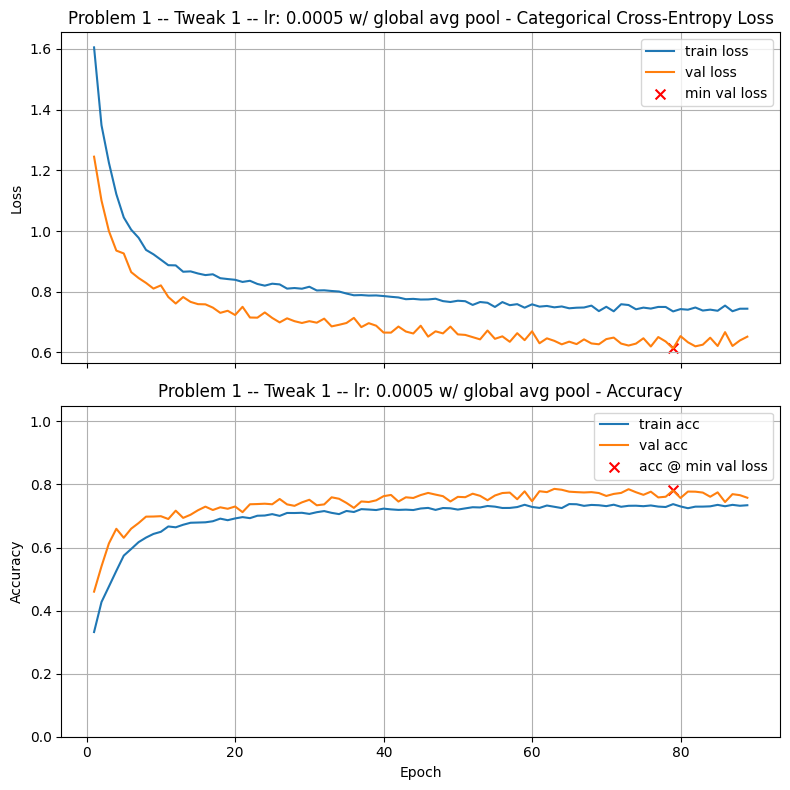

Final Training Loss:            0.7441
Final Training Accuracy:        0.7341
Final Validation Loss:          0.6519
Final Validation Accuracy:      0.7578
Minimum Validation Loss:        0.6133 (Epoch 79)
Validation Accuracy @ Min Loss: 0.7810

Test Loss: 0.6363
Test Accuracy: 0.7750

Validation-Test Gap (accuracy): 0.006027

Execution Time: 00:10:28

Problem 1 -- Tweak 2 -- widen conv layers w/ global avg pool



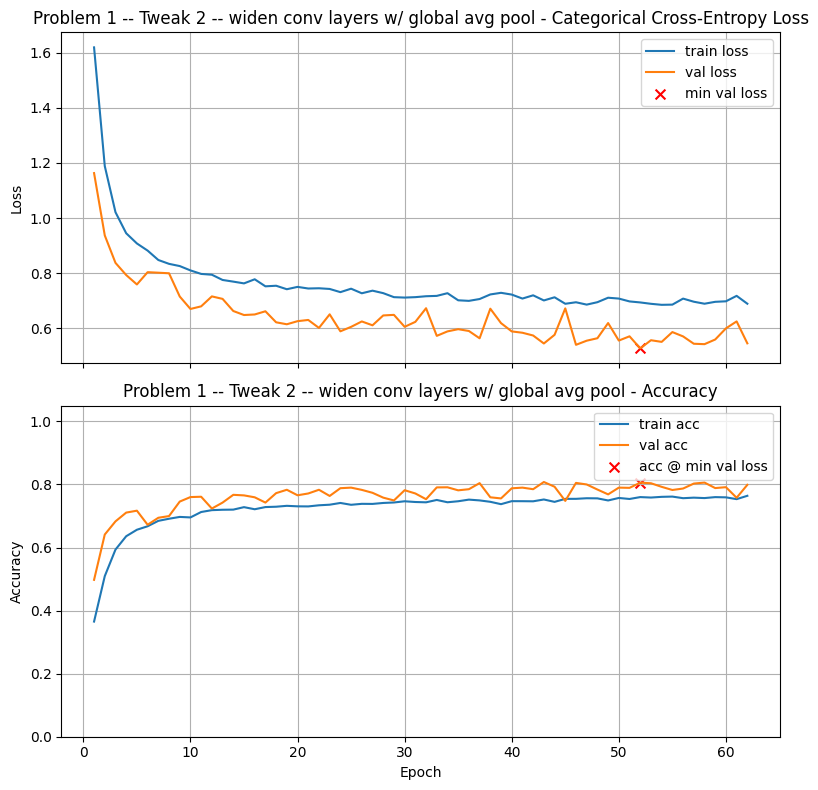

Final Training Loss:            0.6897
Final Training Accuracy:        0.7640
Final Validation Loss:          0.5461
Final Validation Accuracy:      0.7989
Minimum Validation Loss:        0.5278 (Epoch 52)
Validation Accuracy @ Min Loss: 0.8056

Test Loss: 0.5497
Test Accuracy: 0.8033

Validation-Test Gap (accuracy): 0.002301

Execution Time: 00:13:31

Problem 1 -- Tweak 3 -- extra block w/ global avg pool



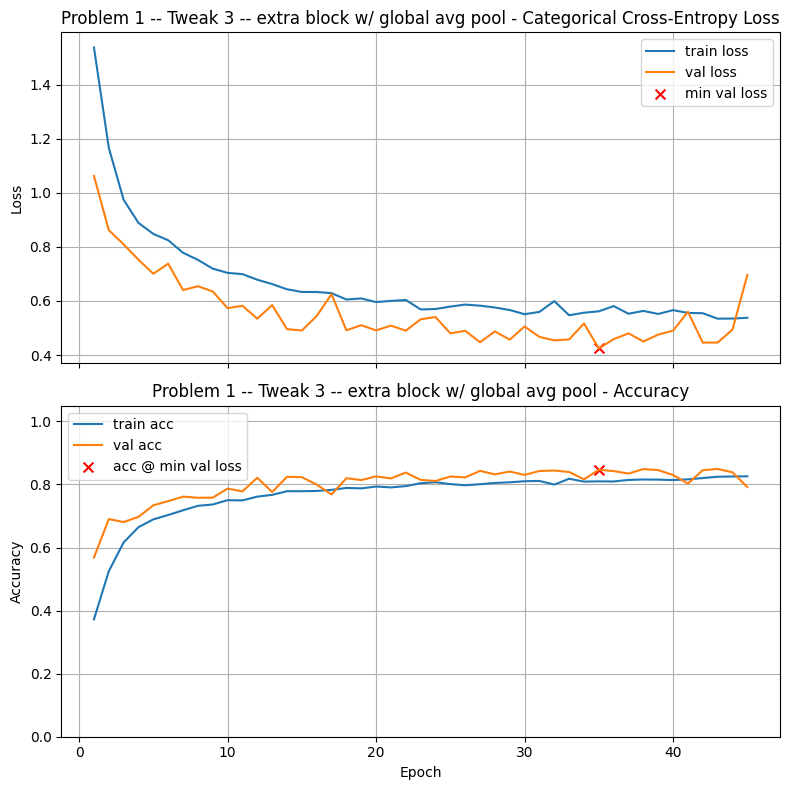

Final Training Loss:            0.5376
Final Training Accuracy:        0.8258
Final Validation Loss:          0.6961
Final Validation Accuracy:      0.7917
Minimum Validation Loss:        0.4246 (Epoch 35)
Validation Accuracy @ Min Loss: 0.8466

Test Loss: 0.4216
Test Accuracy: 0.8530

Validation-Test Gap (accuracy): 0.006352

Execution Time: 00:06:37

Problem 1 -- Tweak 4 -- wider dense 128 w/ global avg pool



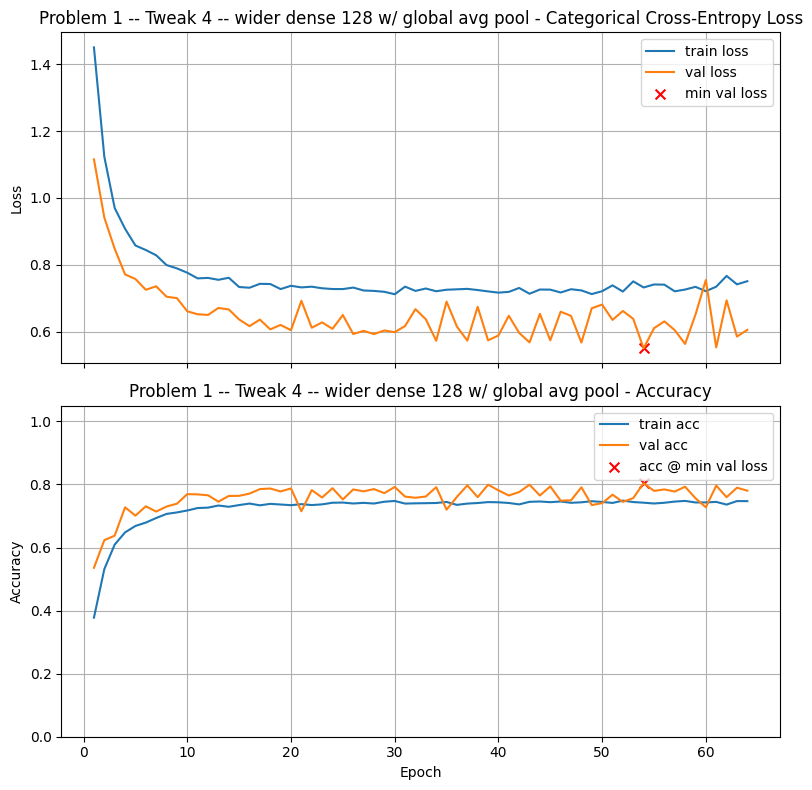

Final Training Loss:            0.7508
Final Training Accuracy:        0.7471
Final Validation Loss:          0.6051
Final Validation Accuracy:      0.7803
Minimum Validation Loss:        0.5497 (Epoch 54)
Validation Accuracy @ Min Loss: 0.8042

Test Loss: 0.5928
Test Accuracy: 0.8013

Validation-Test Gap (accuracy): 0.002875

Execution Time: 00:07:38

Problem 1 -- Tweak 5 -- L2 regularization w/ global avg pool



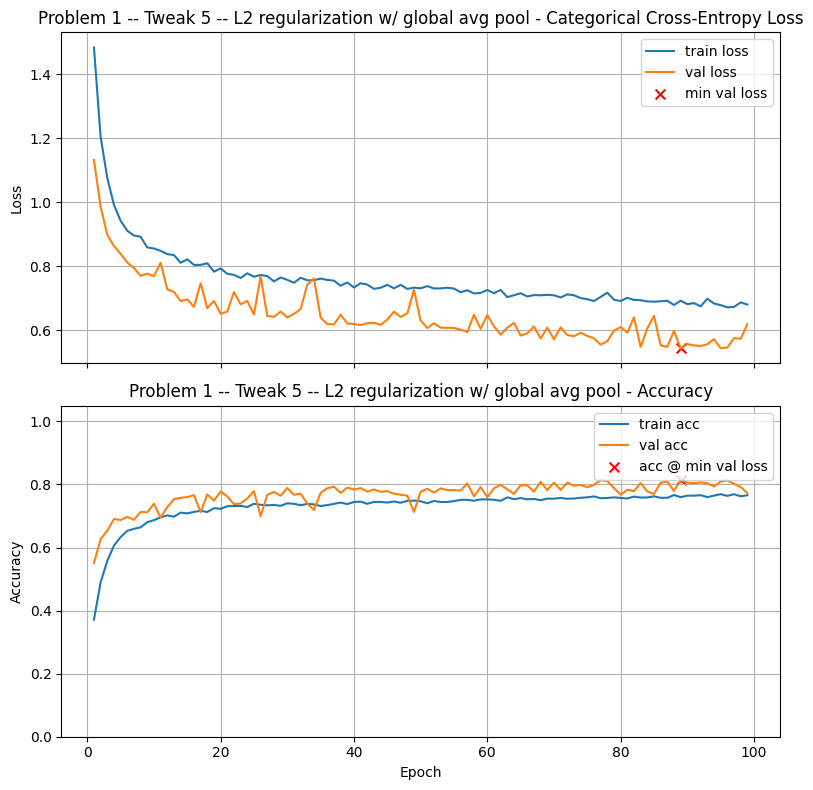

Final Training Loss:            0.6801
Final Training Accuracy:        0.7658
Final Validation Loss:          0.6185
Final Validation Accuracy:      0.7728
Minimum Validation Loss:        0.5431 (Epoch 89)
Validation Accuracy @ Min Loss: 0.8153

Test Loss: 0.5744
Test Accuracy: 0.8023

Validation-Test Gap (accuracy): 0.012931

Execution Time: 00:12:17

Problem 1 -- Tweak 6 -- less dropout 0.3 w/ global avg pool



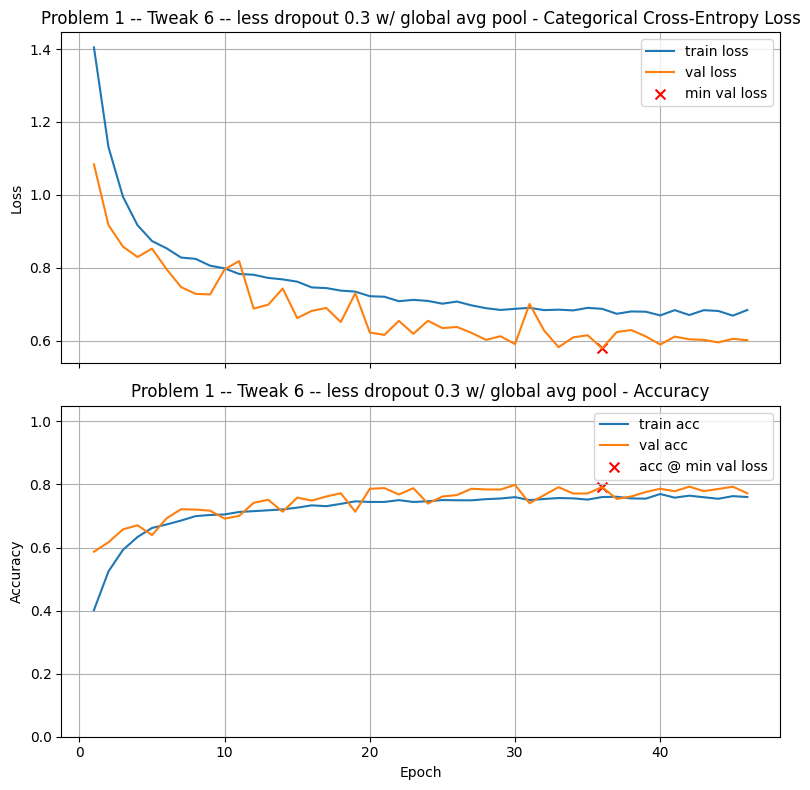

Final Training Loss:            0.6839
Final Training Accuracy:        0.7601
Final Validation Loss:          0.6011
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.5786 (Epoch 36)
Validation Accuracy @ Min Loss: 0.7917

Test Loss: 0.6135
Test Accuracy: 0.7850

Validation-Test Gap (accuracy): 0.006726

Execution Time: 00:05:28

Problem 1 -- Tweak 1 -- lr: 0.0005 w/ batch norm and global avg pool



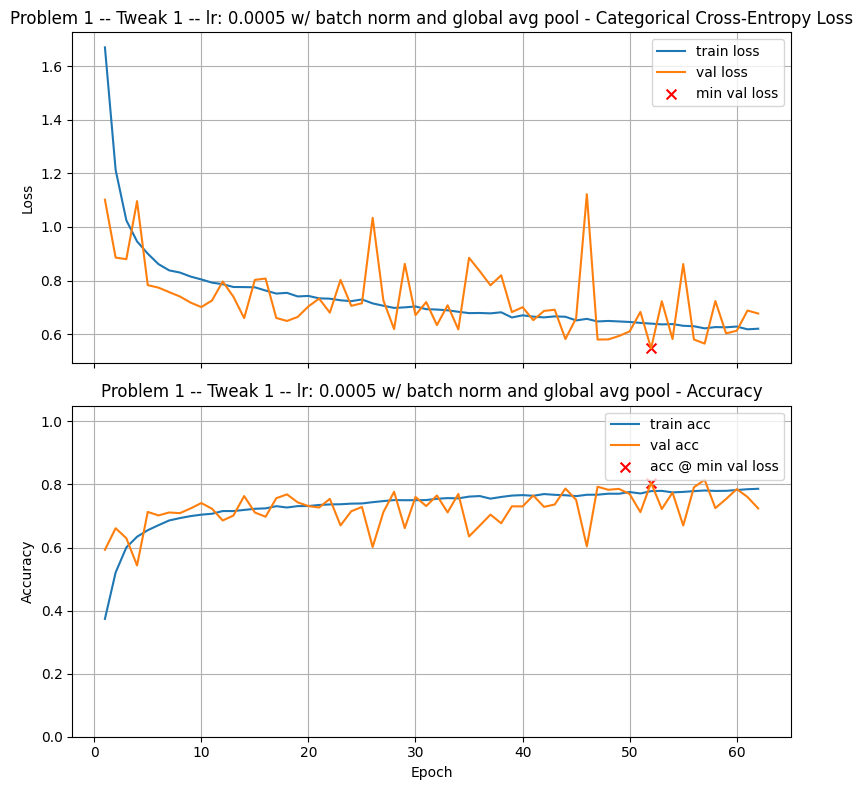

Final Training Loss:            0.6202
Final Training Accuracy:        0.7863
Final Validation Loss:          0.6768
Final Validation Accuracy:      0.7240
Minimum Validation Loss:        0.5467 (Epoch 52)
Validation Accuracy @ Min Loss: 0.8053

Test Loss: 0.5732
Test Accuracy: 0.8000

Validation-Test Gap (accuracy): 0.005278

Execution Time: 00:15:10

Problem 1 -- Tweak 2 -- widen conv layers w/ batch norm and global avg pool



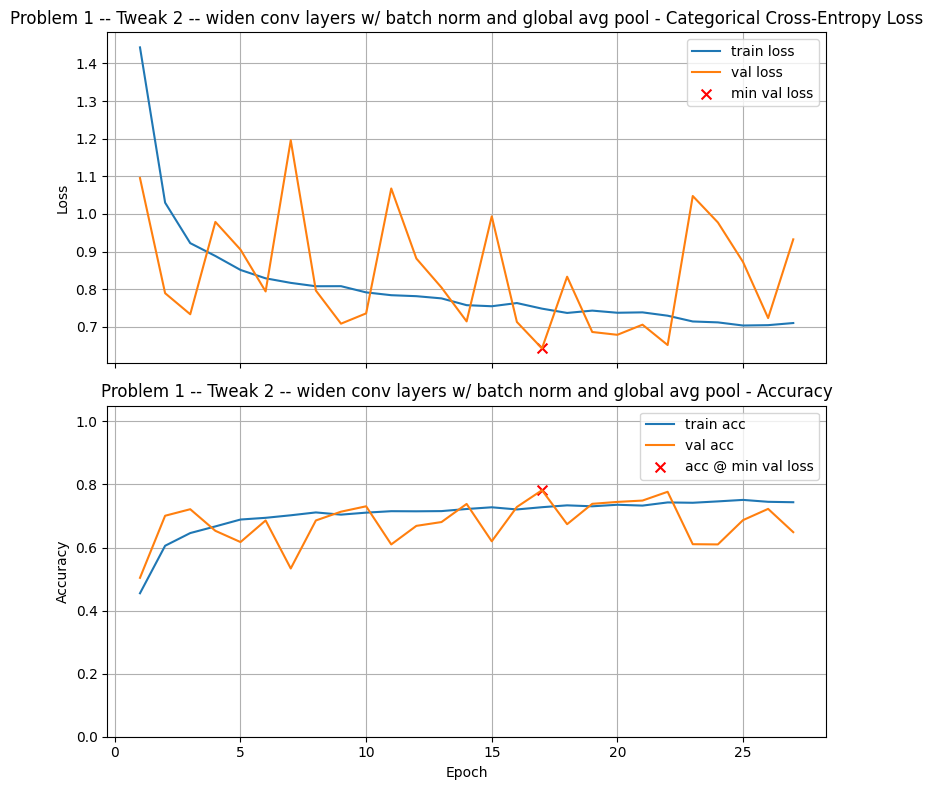

Final Training Loss:            0.7100
Final Training Accuracy:        0.7436
Final Validation Loss:          0.9325
Final Validation Accuracy:      0.6487
Minimum Validation Loss:        0.6426 (Epoch 17)
Validation Accuracy @ Min Loss: 0.7817

Test Loss: 0.6883
Test Accuracy: 0.7653

Validation-Test Gap (accuracy): 0.016407

Execution Time: 00:12:48

Problem 1 -- Tweak 3 -- extra block w/ batch norm and global avg pool



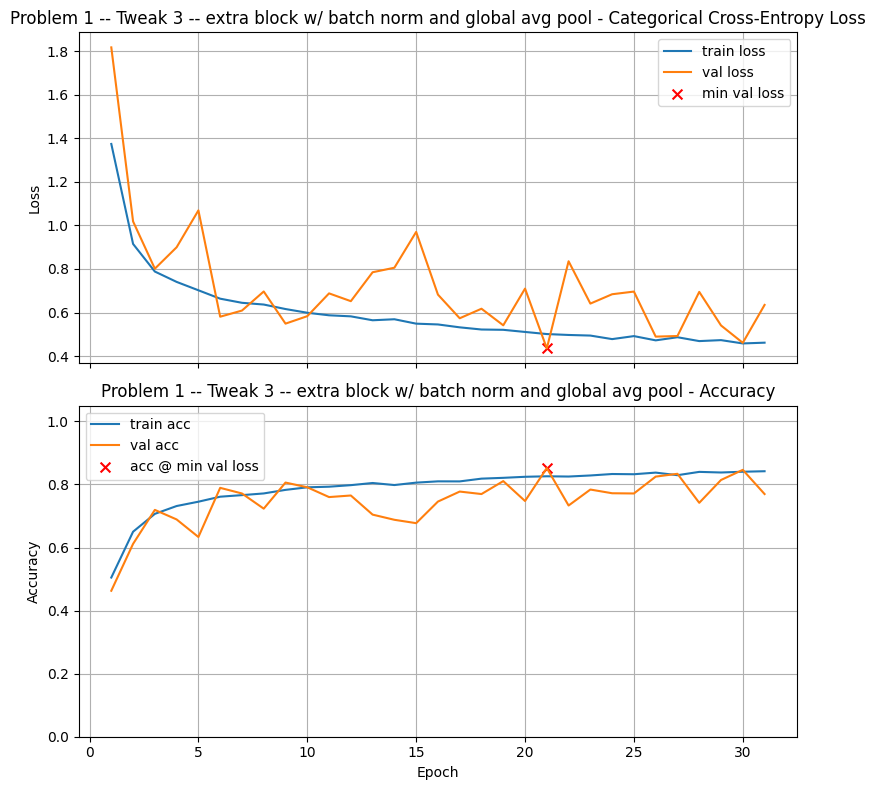

Final Training Loss:            0.4618
Final Training Accuracy:        0.8419
Final Validation Loss:          0.6351
Final Validation Accuracy:      0.7696
Minimum Validation Loss:        0.4356 (Epoch 21)
Validation Accuracy @ Min Loss: 0.8520

Test Loss: 0.4314
Test Accuracy: 0.8533

Validation-Test Gap (accuracy): 0.001336

Execution Time: 00:08:58

Problem 1 -- Tweak 4 -- wider dense 128 w/ batch norm and global avg pool



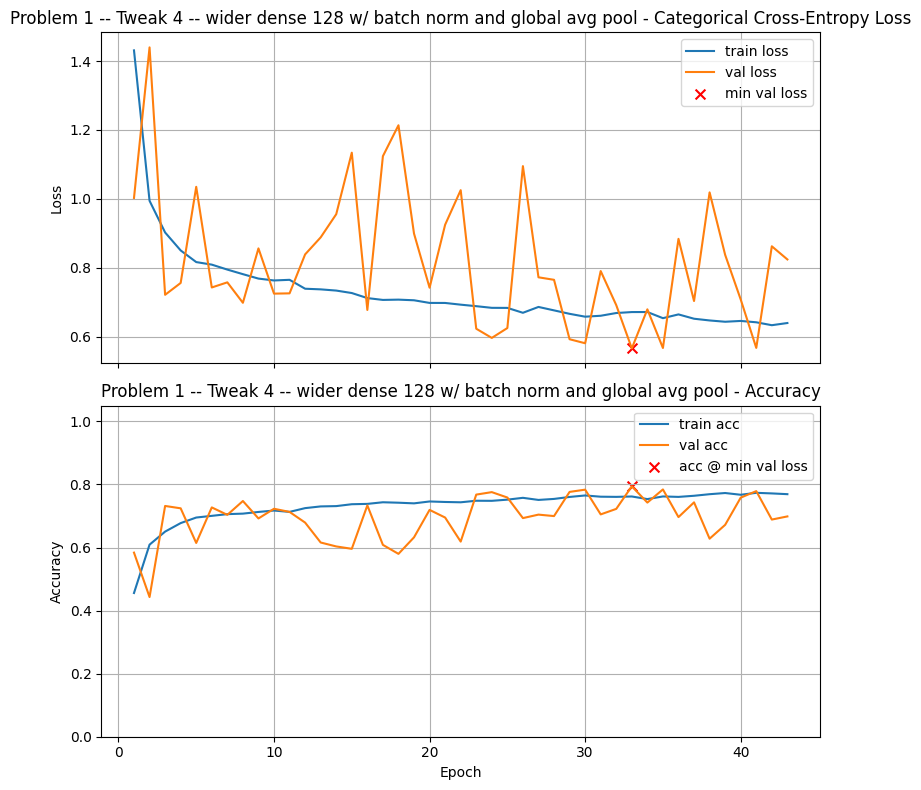

Final Training Loss:            0.6396
Final Training Accuracy:        0.7692
Final Validation Loss:          0.8242
Final Validation Accuracy:      0.6986
Minimum Validation Loss:        0.5660 (Epoch 33)
Validation Accuracy @ Min Loss: 0.7942

Test Loss: 0.5913
Test Accuracy: 0.7837

Validation-Test Gap (accuracy): 0.010556

Execution Time: 00:10:32

Problem 1 -- Tweak 5 -- L2 regularization w/ batch norm and global avg pool



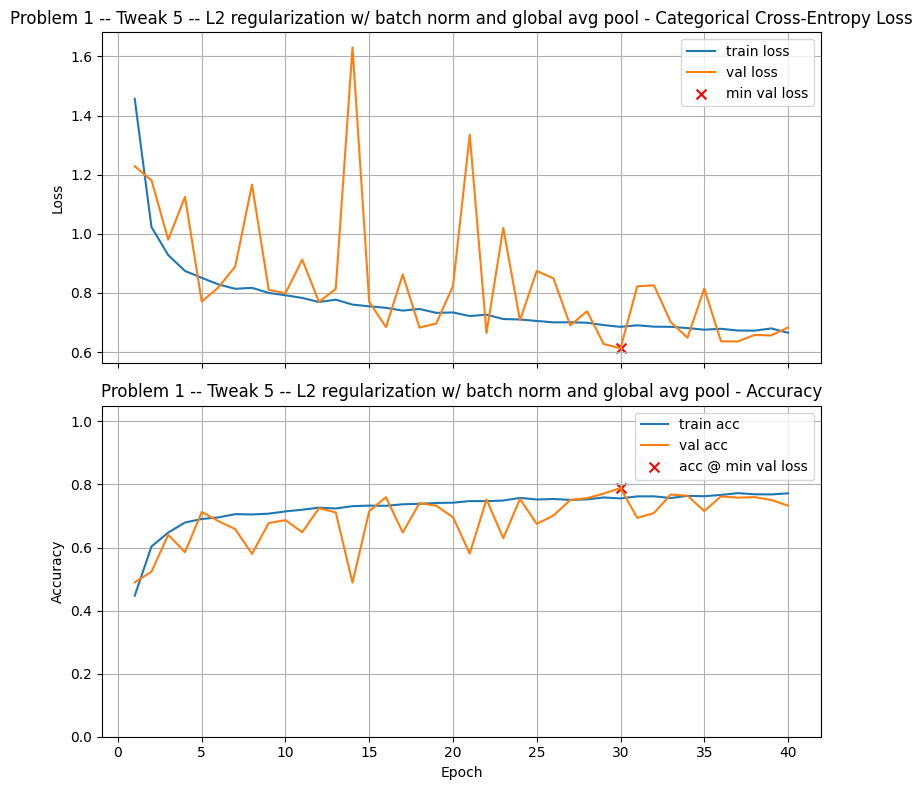

Final Training Loss:            0.6654
Final Training Accuracy:        0.7719
Final Validation Loss:          0.6832
Final Validation Accuracy:      0.7329
Minimum Validation Loss:        0.6125 (Epoch 30)
Validation Accuracy @ Min Loss: 0.7885

Test Loss: 0.6465
Test Accuracy: 0.7767

Validation-Test Gap (accuracy): 0.011850

Execution Time: 00:09:48

Problem 1 -- Tweak 6 -- less dropout 0.3 w/ batch norm and global avg pool



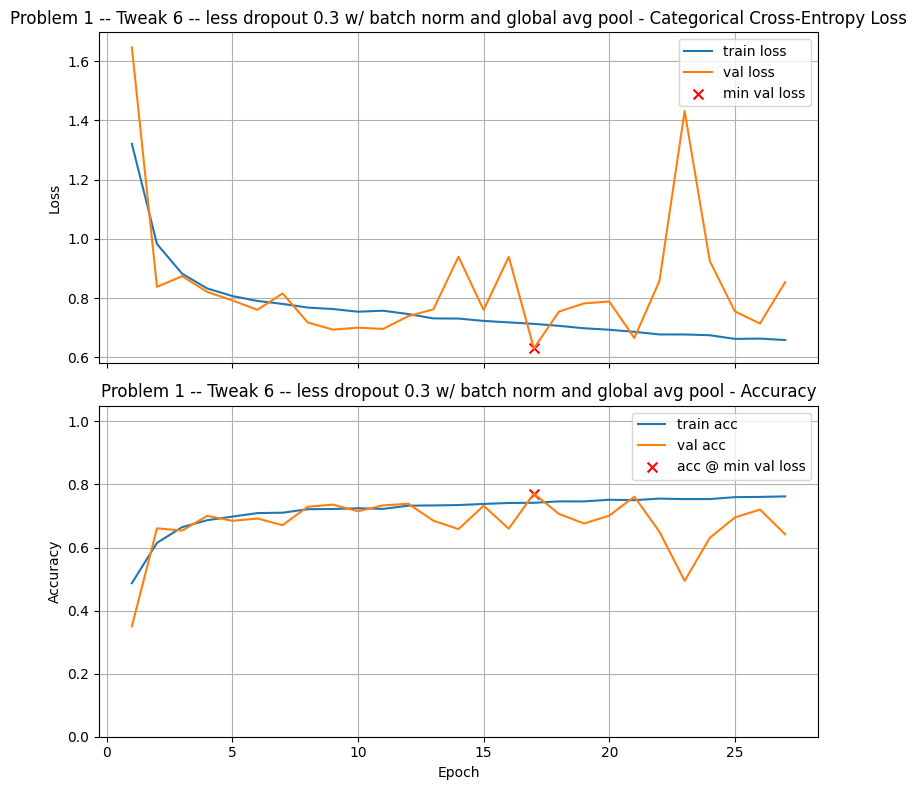

Final Training Loss:            0.6584
Final Training Accuracy:        0.7622
Final Validation Loss:          0.8537
Final Validation Accuracy:      0.6419
Minimum Validation Loss:        0.6302 (Epoch 17)
Validation Accuracy @ Min Loss: 0.7710

Test Loss: 0.6512
Test Accuracy: 0.7700

Validation-Test Gap (accuracy): 0.001041

Execution Time: 00:06:40


In [ ]:
# For each of the models, replace flatten with global average pooling

# Tweak 1: Adjust learning rate to 0.0005 w/ global avg pool
model1_lr_adjust=models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model1_lr_adjust,title=f"Problem 1 -- Tweak 1 -- lr: 0.0005 w/ global avg pool",
               lr_schedule=0.0005)

# Tweak 2: widen conv layers w/ global avg pool
model2_width_conv_adjust =models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model2_width_conv_adjust,title=f"Problem 1 -- Tweak 2 -- widen conv layers w/ global avg pool")

# Tweak 3: add extra conv block w/ global avg pool
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", kernel_initializer=he, padding="same"),  # extra block
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 1 -- Tweak 3 -- extra block w/ global avg pool")

# Tweak 4: widen dense layer w/ global avg pool
model4_wider_dense = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model4_wider_dense,title=f"Problem 1 -- Tweak 4 -- wider dense 128 w/ global avg pool")

# Tweak 5: L2 regularization on dense layer w/ global avg pool
model5_l2 = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model5_l2,title=f"Problem 1 -- Tweak 5 -- L2 regularization w/ global avg pool")

# Tweak 6: less dropout w/ global avg pool
model6_dropout_change = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", kernel_initializer=he, padding="same"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.3),  # less dropout
    Dense(num_classes, activation="softmax")
])
train_and_test(model6_dropout_change,title=f"Problem 1 -- Tweak 6 -- less dropout 0.3 w/ global avg pool")


# Tweak 1: Adjust learning rate to 0.0005 w/ batch norm and global avg pool
model1_lr_adjust=models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model1_lr_adjust,title=f"Problem 1 -- Tweak 1 -- lr: 0.0005 w/ batch norm and global avg pool",
               lr_schedule=0.0005)

# Tweak 2: widen conv layers w/ batch norm and global avg pool
model2_width_conv_adjust =models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model2_width_conv_adjust,title=f"Problem 1 -- Tweak 2 -- widen conv layers w/ batch norm and global avg pool")

# Tweak 3: add extra conv block w/ batch norm and global avg pool
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),  # extra block
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 1 -- Tweak 3 -- extra block w/ batch norm and global avg pool")

# Tweak 4: widen dense layer w/ batch norm and global avg pool
model4_wider_dense = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model4_wider_dense,title=f"Problem 1 -- Tweak 4 -- wider dense 128 w/ batch norm and global avg pool")

# Tweak 5: L2 regularization on dense layer w/ batch norm and global avg pool
model5_l2 = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he, kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model5_l2,title=f"Problem 1 -- Tweak 5 -- L2 regularization w/ batch norm and global avg pool")

# Tweak 6: less dropout w/ batch norm and global avg pool
model6_dropout_change = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.3),  # less dropout
    Dense(num_classes, activation="softmax")
])
train_and_test(model6_dropout_change,title=f"Problem 1 -- Tweak 6 -- less dropout 0.3 w/ batch norm and global avg pool")

### Graded Questions

In [ ]:
# Set a3a to the number of the individual "tweak" which provided the best validation accuracy at the epoch of minimum validation loss

a3a = 3             # Replace with integer 1 - 6; replace with 0 if you found no tweak which improved the results

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a}')


a3a = 3


In [ ]:
# Set a3b to the validation accuracy found by the choice specified in Question a3a (your best model for this problem)

a3b = 0.8520             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.8520


## Problem Four: ReduceLROnPlateau

`ReduceLROnPlateau` is a widely used learning rate scheduling technique. It monitors a validation metric (usually `val_loss`) and reduces the learning rate when progress stalls, allowing the model to refine training at a smaller step size. This is one of the most useful scheduling tools (along with the essential Early Stopping) to have in your toolbox.

**Task:**
Augment your best model found so far in Problems 1 - 3 with the `ReduceLROnPlateau` callback during training.

**Next Steps:**

* Add the callback parameter to `train_and_test`:

  ```python
  callbacks=[reduce_lr]
  ```

* Start with **`factor=0.5`** (monitor `val_loss`, `patience=2–3`, `cooldown=1`, `min_lr=1e-5` for Adam).
* **Practical playbook:**

  * If plateau persists after one reduction → try **`factor=0.3`**, then **`0.2`**.
  * If a reduction hurts validation noticeably → try **`factor=0.7–0.8`** or increase **`patience`**.
  * Leave **`cooldown=1`** unless you see too-frequent drops.
* Experiment with **`patience` = 3, 5, 8** and **`min_delta` = `1e-4` vs `1e-3`** to gauge sensitivity.
* Choose the configuration with the best validation results—or note that ReduceLROnPlateau didn’t help (rare!).
* Answer the graded questions.




Problem 4 -- Tweak 1 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 3, Cooldown 1



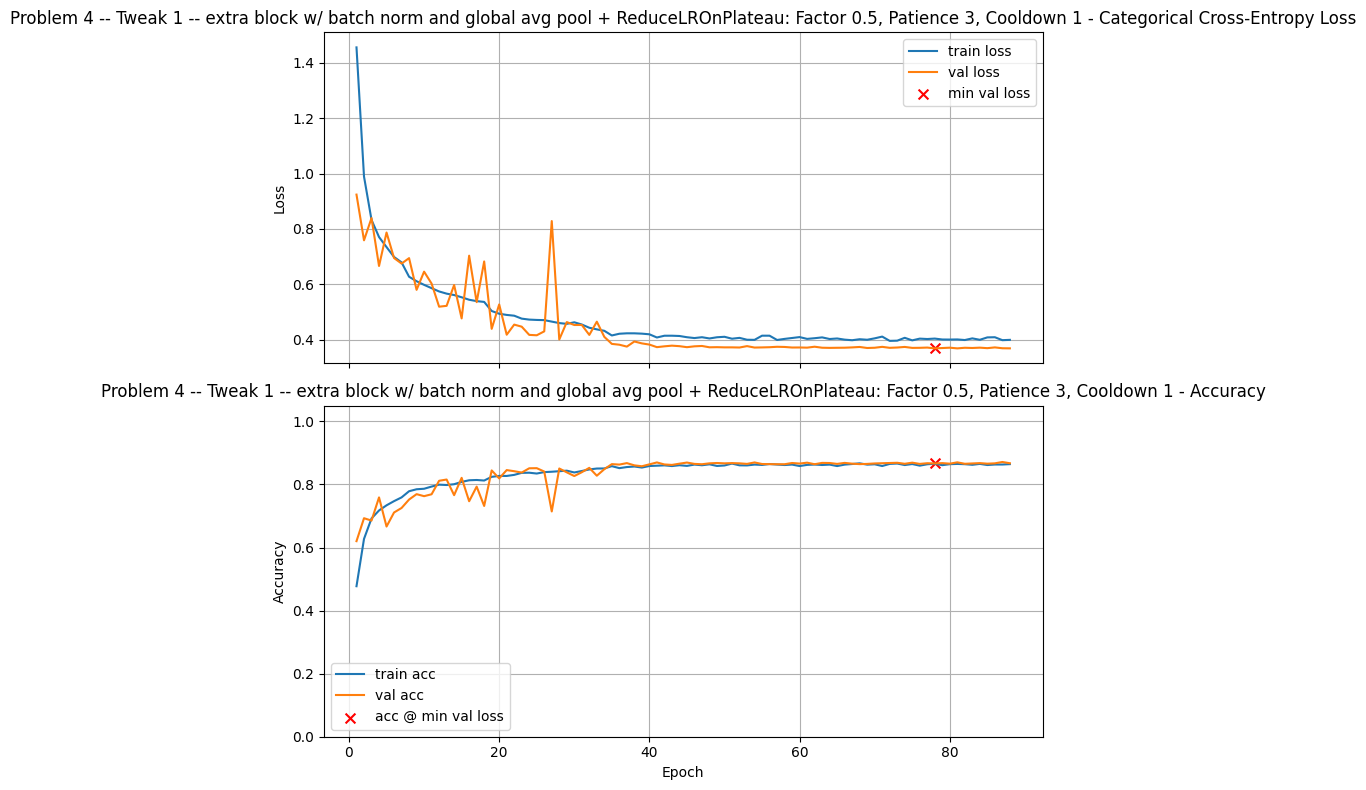

Final Training Loss:            0.3993
Final Training Accuracy:        0.8645
Final Validation Loss:          0.3686
Final Validation Accuracy:      0.8673
Minimum Validation Loss:        0.3686 (Epoch 78)
Validation Accuracy @ Min Loss: 0.8666

Test Loss: 0.3695
Test Accuracy: 0.8683

Validation-Test Gap (accuracy): 0.001714

Execution Time: 00:25:43

Problem 4 -- Tweak 2 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.3, Patience 3, Cooldown 1



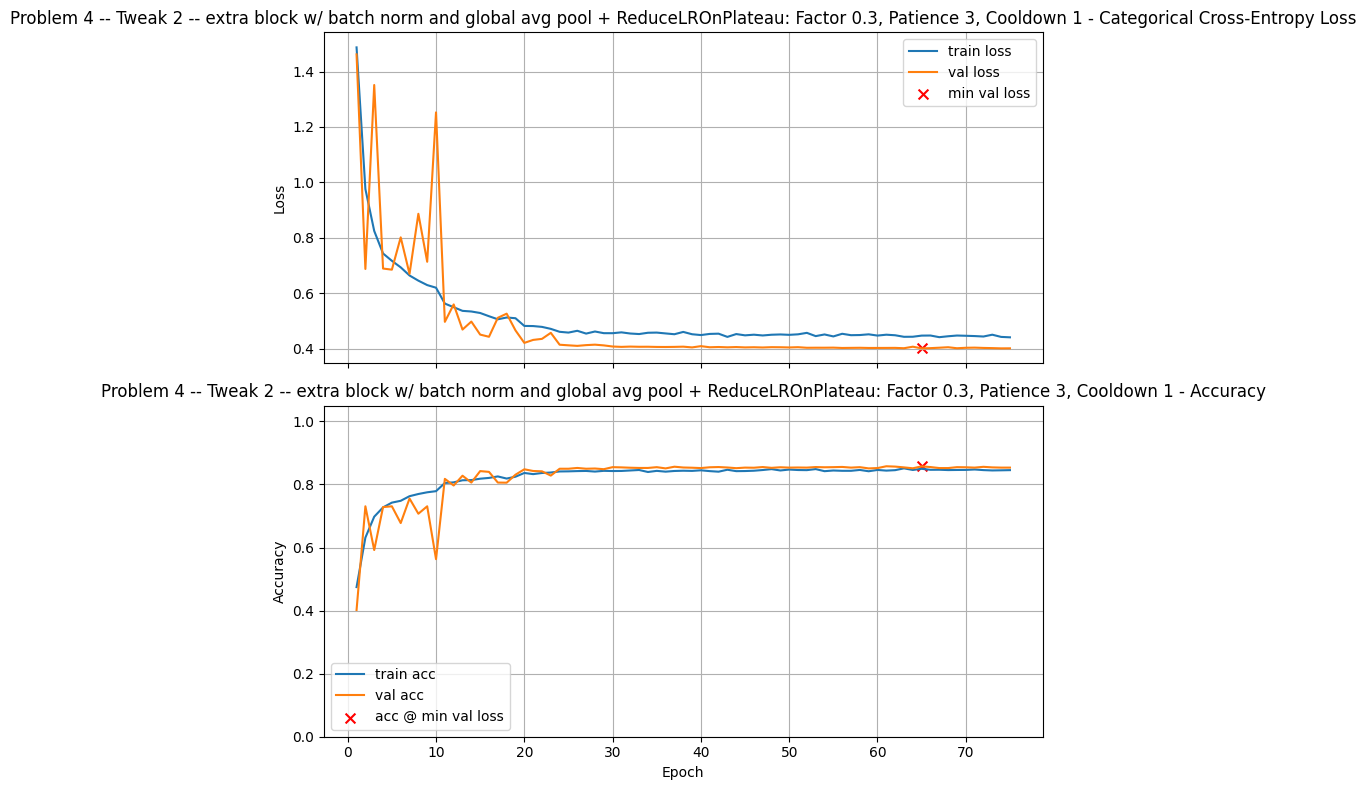

Final Training Loss:            0.4418
Final Training Accuracy:        0.8454
Final Validation Loss:          0.4022
Final Validation Accuracy:      0.8534
Minimum Validation Loss:        0.4020 (Epoch 65)
Validation Accuracy @ Min Loss: 0.8573

Test Loss: 0.3989
Test Accuracy: 0.8637

Validation-Test Gap (accuracy): 0.006320

Execution Time: 00:22:13

Problem 4 -- Tweak 3 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.2, Patience 3, Cooldown 1



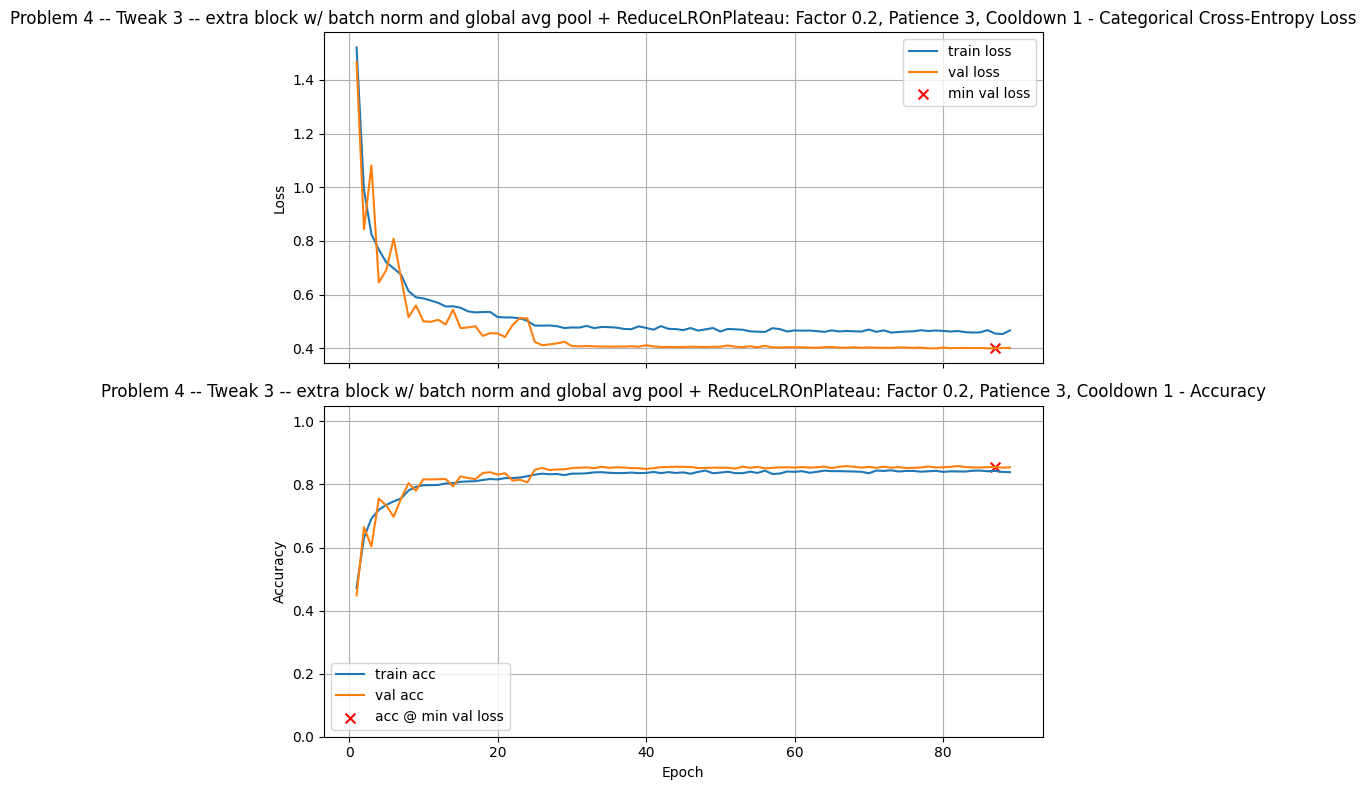

Final Training Loss:            0.4665
Final Training Accuracy:        0.8390
Final Validation Loss:          0.4016
Final Validation Accuracy:      0.8545
Minimum Validation Loss:        0.3995 (Epoch 87)
Validation Accuracy @ Min Loss: 0.8556

Test Loss: 0.4075
Test Accuracy: 0.8587

Validation-Test Gap (accuracy): 0.004886

Execution Time: 00:26:29

Problem 4 -- Tweak 4 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.7, Patience 3, Cooldown 1



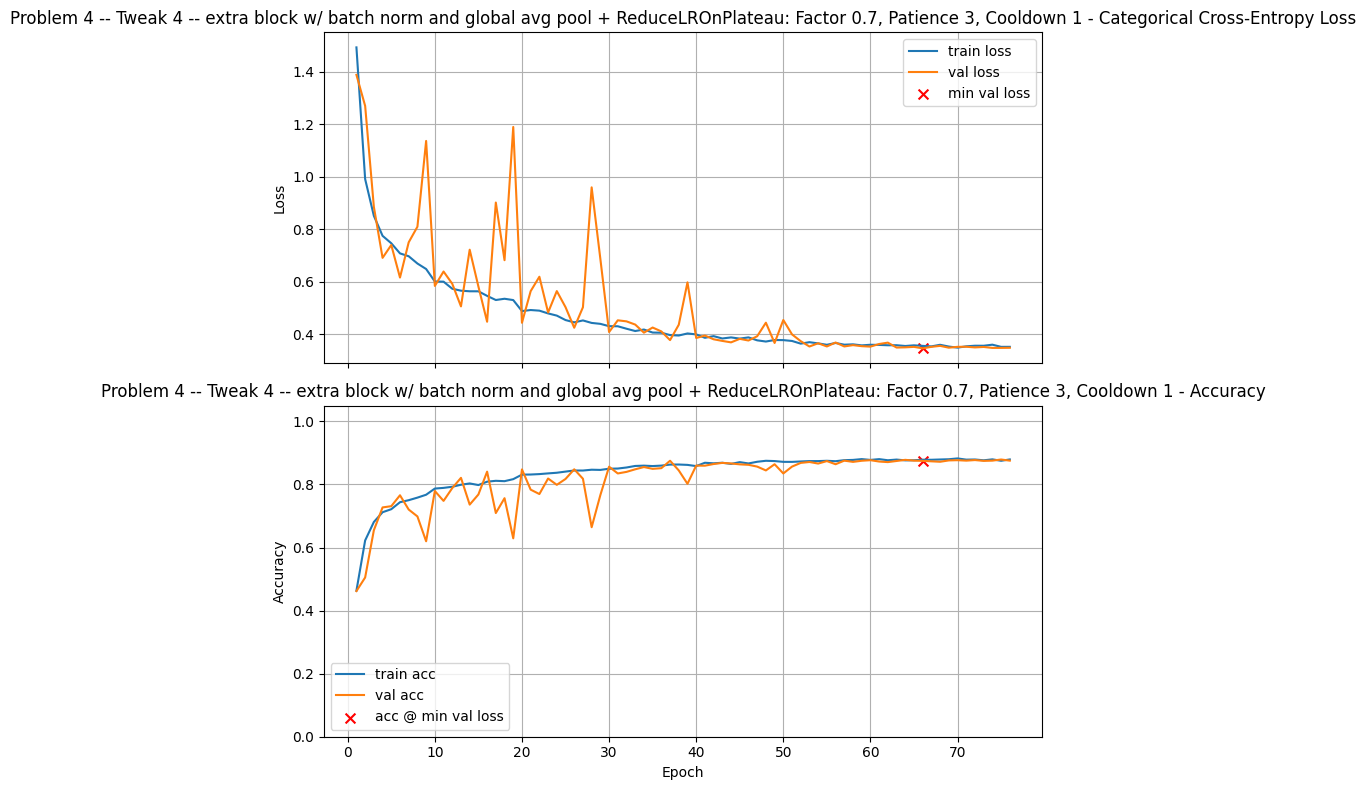

Final Training Loss:            0.3530
Final Training Accuracy:        0.8793
Final Validation Loss:          0.3494
Final Validation Accuracy:      0.8755
Minimum Validation Loss:        0.3471 (Epoch 66)
Validation Accuracy @ Min Loss: 0.8748

Test Loss: 0.3447
Test Accuracy: 0.8857

Validation-Test Gap (accuracy): 0.010845

Execution Time: 00:22:26

Problem 4 -- Tweak 5 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.8, Patience 3, Cooldown 1



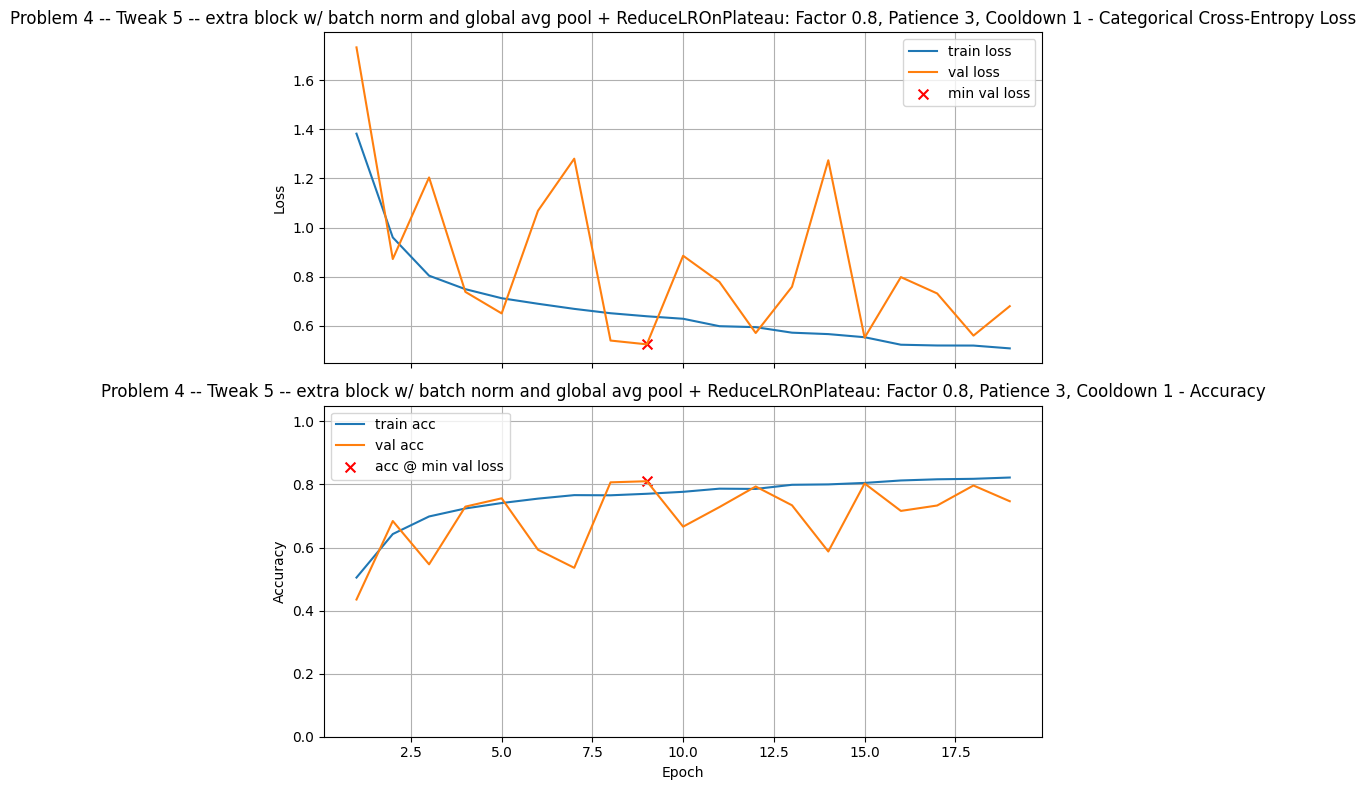

Final Training Loss:            0.5075
Final Training Accuracy:        0.8220
Final Validation Loss:          0.6795
Final Validation Accuracy:      0.7468
Minimum Validation Loss:        0.5240 (Epoch 9)
Validation Accuracy @ Min Loss: 0.8103

Test Loss: 0.5399
Test Accuracy: 0.8100

Validation-Test Gap (accuracy): 0.000271

Execution Time: 00:05:27

Problem 4 -- Tweak 6 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 5, Cooldown 1



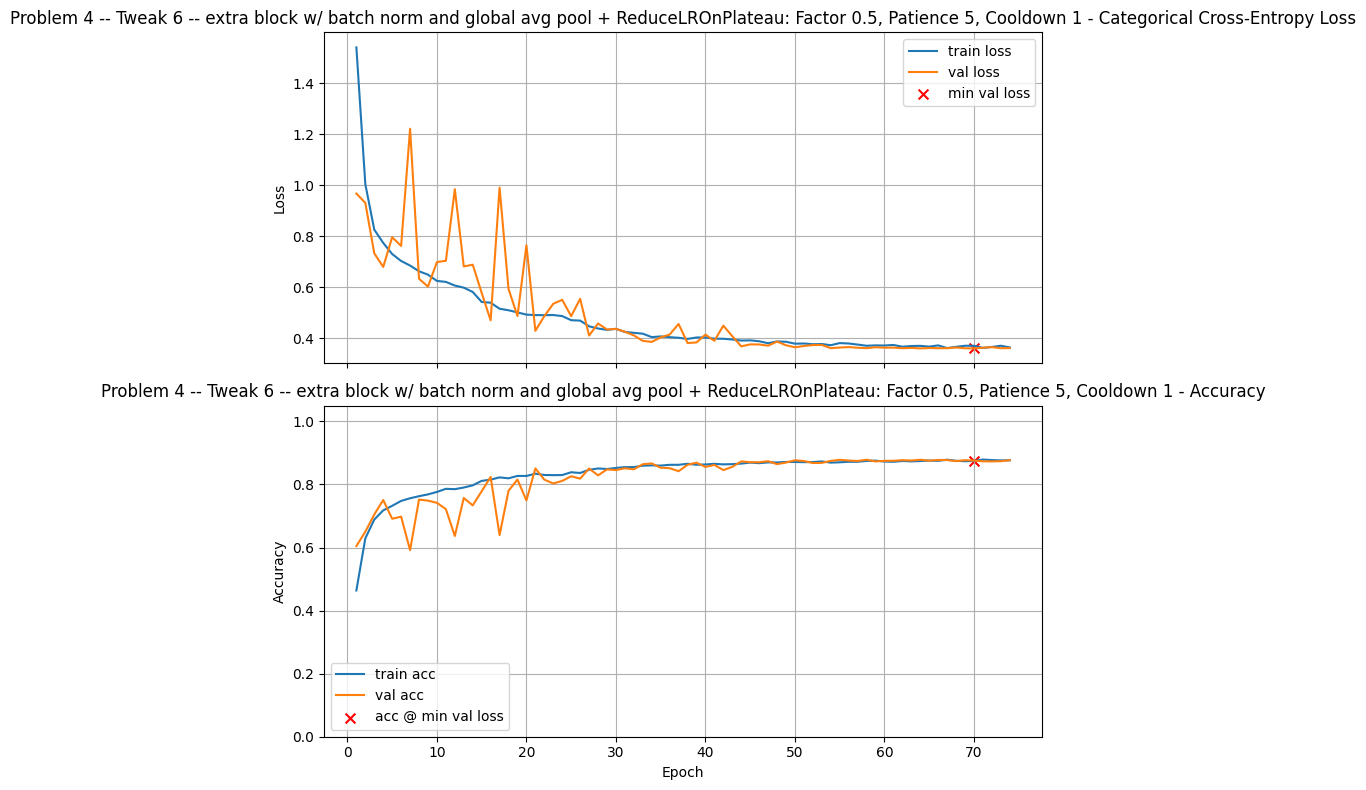

Final Training Loss:            0.3649
Final Training Accuracy:        0.8767
Final Validation Loss:          0.3623
Final Validation Accuracy:      0.8770
Minimum Validation Loss:        0.3612 (Epoch 70)
Validation Accuracy @ Min Loss: 0.8755

Test Loss: 0.3523
Test Accuracy: 0.8757

Validation-Test Gap (accuracy): 0.002721

Execution Time: 00:21:43

Problem 4 -- Tweak 7 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 8, Cooldown 1



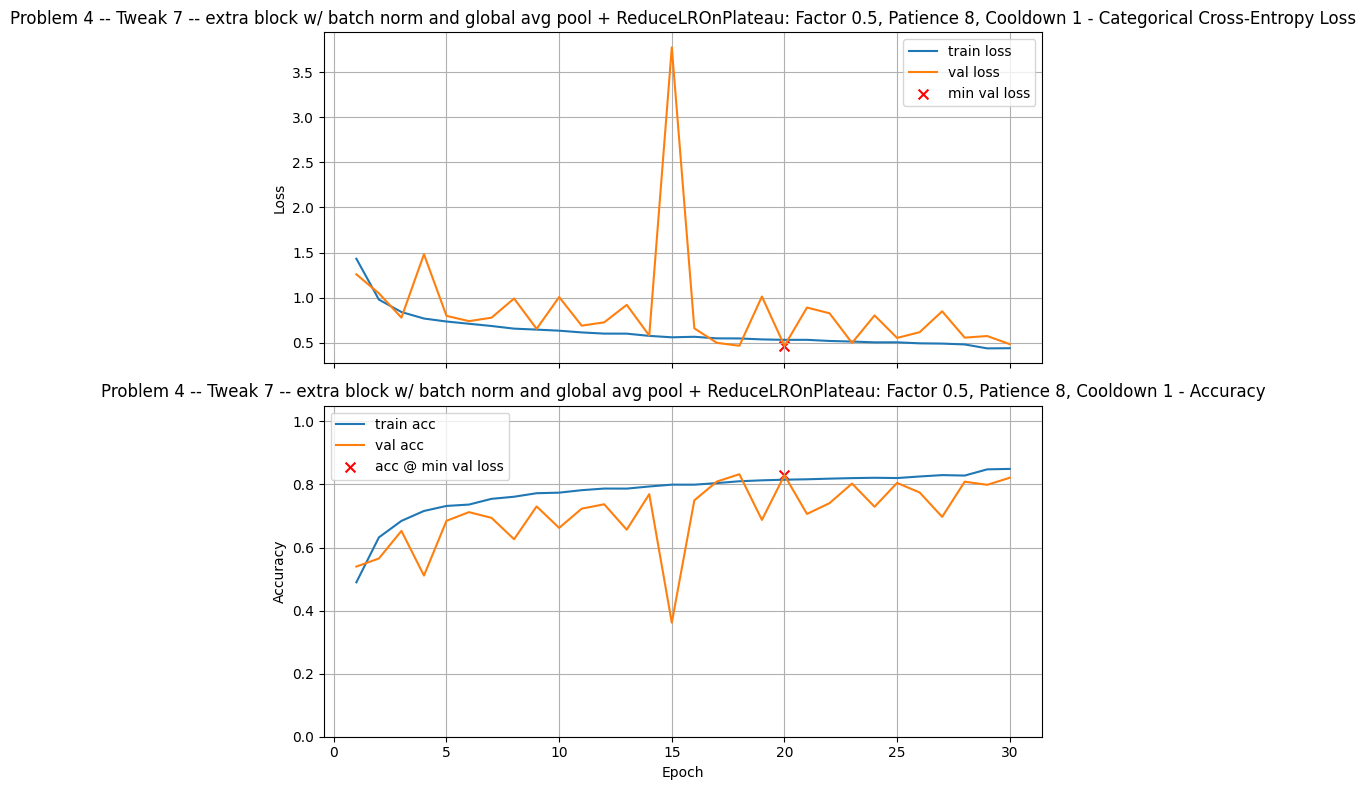

Final Training Loss:            0.4395
Final Training Accuracy:        0.8493
Final Validation Loss:          0.4842
Final Validation Accuracy:      0.8213
Minimum Validation Loss:        0.4655 (Epoch 20)
Validation Accuracy @ Min Loss: 0.8292

Test Loss: 0.4962
Test Accuracy: 0.8283

Validation-Test Gap (accuracy): 0.000839

Execution Time: 00:08:41

Problem 4 -- Tweak 8 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 3, Cooldown 1, Min Delta 1e-3



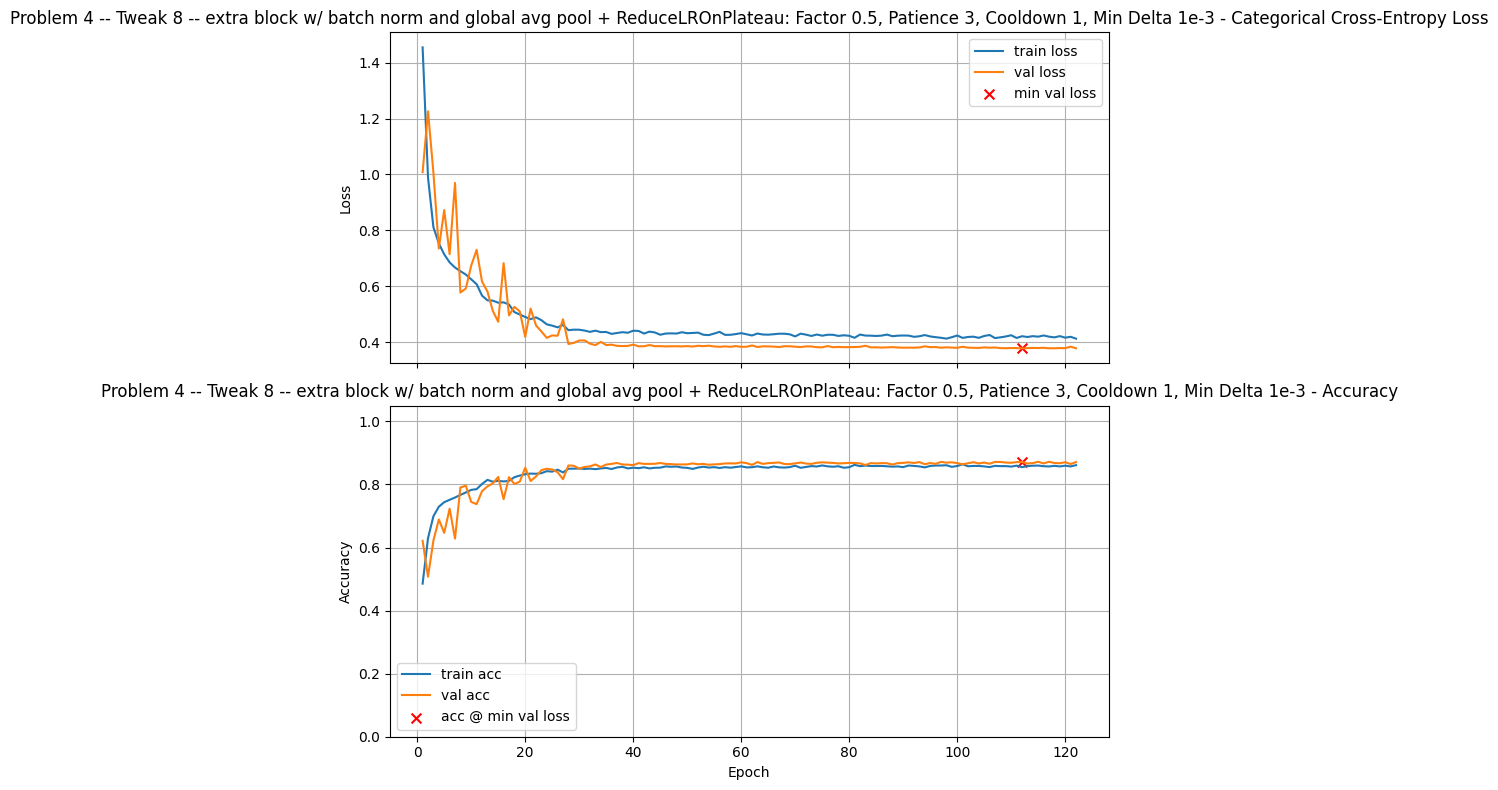

Final Training Loss:            0.4128
Final Training Accuracy:        0.8612
Final Validation Loss:          0.3784
Final Validation Accuracy:      0.8709
Minimum Validation Loss:        0.3780 (Epoch 112)
Validation Accuracy @ Min Loss: 0.8713

Test Loss: 0.3741
Test Accuracy: 0.8703

Validation-Test Gap (accuracy): 0.000922

Execution Time: 00:36:06


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=1,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)
he = initializers.HeNormal()                                # best initializer for relu
from tensorflow.keras.layers import Activation

# Tweak 1: add extra conv block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 3, Cooldown 1
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),

    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),  # extra block
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 4 -- Tweak 1 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 3, Cooldown 1",
               callbacks=[reduce_lr])

# Tweak 2: add extra conv block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.3, Patience 3, Cooldown 1
reduce_lr_2 = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.3,            # Factor by which the learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
    patience=3,            # Number of epochs with no improvement
    cooldown=1,            # Number of epochs to wait before resuming
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),  # extra block
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 4 -- Tweak 2 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.3, Patience 3, Cooldown 1",
               callbacks=[reduce_lr_2])

# Tweak 3: add extra conv block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.2, Patience 3, Cooldown 1
reduce_lr_3 = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.2,            # Factor by which the learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
    patience=3,            # Number of epochs with no improvement
    cooldown=1,            # Number of epochs to wait before resuming
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),  # extra block
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 4 -- Tweak 3 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.2, Patience 3, Cooldown 1",
               callbacks=[reduce_lr_3])

# Tweak 4: add extra conv block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.7, Patience 3, Cooldown 1
reduce_lr_4 = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.7,            # Factor by which the learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
    patience=3,            # Number of epochs with no improvement
    cooldown=1,            # Number of epochs to wait before resuming
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),  # extra block
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 4 -- Tweak 4 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.7, Patience 3, Cooldown 1",
               callbacks=[reduce_lr_4])

# Tweak 5: add extra conv block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.8, Patience 3, Cooldown 1
reduce_lr_5 = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.8,            # Factor by which the learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
    patience=3,            # Number of epochs with no improvement
    cooldown=1,            # Number of epochs to wait before resuming
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),  # extra block
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 4 -- Tweak 5 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.8, Patience 3, Cooldown 1",
               callbacks=[reduce_lr_5])

# Tweak 6: add extra conv block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 5, Cooldown 1
reduce_lr_6 = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
    patience=5,            # Number of epochs with no improvement
    cooldown=1,            # Number of epochs to wait before resuming
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),  # extra block
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 4 -- Tweak 6 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 5, Cooldown 1",
               callbacks=[reduce_lr_6])

# Tweak 7: add extra conv block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 8, Cooldown 1
reduce_lr_7 = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
    patience=8,            # Number of epochs with no improvement
    cooldown=1,            # Number of epochs to wait before resuming
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),  # extra block
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 4 -- Tweak 7 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 8, Cooldown 1",
               callbacks=[reduce_lr_7])

# Tweak 8: add extra conv block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 3, Cooldown 1, Min Delta 1e-3
reduce_lr_8 = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
    min_delta=1e-3,        # Threshold for measuring the new optimum,
    patience=3,            # Number of epochs with no improvement
    cooldown=1,            # Number of epochs to wait before resuming
    min_lr=1e-5,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)
model3_extra_block = models.Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(32, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation=None, kernel_initializer=he, padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation=None, kernel_initializer=he, padding="same"),  # extra block
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(64, activation="relu",kernel_initializer=he),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])
train_and_test(model3_extra_block,title=f"Problem 4 -- Tweak 8 -- extra block w/ batch norm and global avg pool + ReduceLROnPlateau: Factor 0.5, Patience 3, Cooldown 1, Min Delta 1e-3",
               callbacks=[reduce_lr_8])

### Graded Questions

In [ ]:
# Set a4a to the factor parameter which gave the best validation accuracy at the point of minimum validation loss

a4a = 0.5             # Replace with your best factor value, or leave at 0.0 if reduce on plateau did not help at all

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.2f}')

a4a = 0.50


In [ ]:
# Set a4b to the validation accuracy found by the choice specified in Question a4a (your best model for this problem)

a4b = 0.8755             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.8755


## Problem Five: A Very Deep CNN (VGG-16 Style)

 We will now experiment with the VGG-16 design introduced in the Coding Notebook and Video and see how it does on this dataset. For a beautiful description of the model and its significance, see [Explanation of VGG-16](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/) :
        

![Screenshot 2025-09-19 at 6.50.24 AM.png](attachment:62fa0824-bb06-4663-a6a5-da8cca8f4ab3.png)


In this exercise you’ll **only vary the learning rate**. Don’t change any other hyperparameters. Your goal is to observe how LR affects convergence speed, stability, and final validation performance compared to your smaller baselines. This sets up next week’s **transfer learning** with pretrained models.

#### Starting point

* Optimizer: **Adam**
* **Recommended LR to start:** `1e-3`(Adam default)

#### What LR values to try (coarse → fine)

Try a short sweep like:

```
[1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
```

Then, as time allows,  zoom in around the best.

#### How to judge “best”

* Primary: **best validation accuracy at epoch of lowest validation loss**
* Secondary: **time-to-best** (fewer epochs to reach a strong val metric) and **curve shape** (smooth vs. noisy/oscillatory).

#### What symptoms mean

* **LR too high:** training loss spikes or oscillates; val metrics erratic, occasional NaNs/divergence.
* **LR too low:** very slow improvement; long flat regions; never reaches your smaller models’ performance.


**Tip:** Keep LR **constant** during each run (don’t schedule) so you isolate its effect.




VGG-style Large - LR: 0.01

Epoch 1/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 88ms/step - accuracy: 0.1676 - loss: 255465.3594 - val_accuracy: 0.1698 - val_loss: 1.8259
Epoch 2/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.1766 - loss: 1.8240 - val_accuracy: 0.1790 - val_loss: 1.8188
Epoch 3/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.1785 - loss: 1.8188 - val_accuracy: 0.1790 - val_loss: 1.8157
Epoch 4/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.1760 - loss: 1.8154 - val_accuracy: 0.1790 - val_loss: 1.8141
Epoch 5/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.1800 - loss: 1.8136 - val_accuracy: 0.1698 - val_loss: 1.8133
Epoch 6/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.1740 - loss: 1.8136 - val_accuracy: 0.1698 - val_loss: 1.8124
Epoch 7/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.1825 - loss: 1.8112 - val_accuracy: 0.1619 - val_loss: 1.8118
Epoch 8/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step -

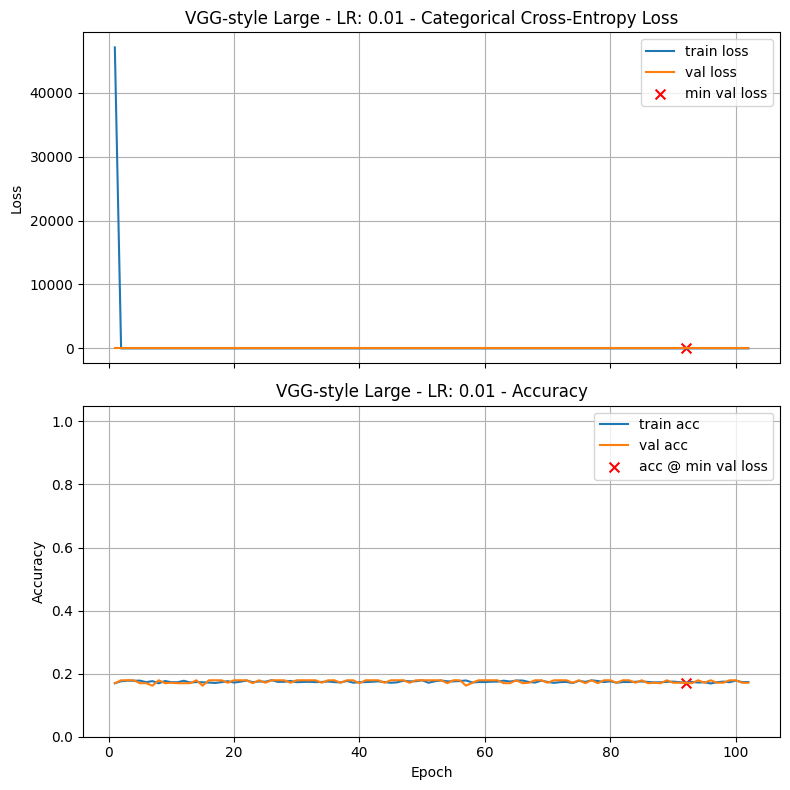

Final Training Loss:            1.7920
Final Training Accuracy:        0.1734
Final Validation Loss:          1.7917
Final Validation Accuracy:      0.1712
Minimum Validation Loss:        1.7910 (Epoch 92)
Validation Accuracy @ Min Loss: 0.1712

Test Loss: 1.7896
Test Accuracy: 0.1843

Validation-Test Gap (accuracy): 0.013149

Execution Time: 00:17:12

VGG-style Large - LR: 0.003

Epoch 1/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.1879 - loss: 13.0870 - val_accuracy: 0.4429 - val_loss: 1.2887
Epoch 2/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4474 - loss: 1.2920 - val_accuracy: 0.5927 - val_loss: 1.0907
Epoch 3/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5854 - loss: 1.0590 - val_accuracy: 0.6337 - val_loss: 0.9050
Epoch 4/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6330 - loss: 0.9274 - val_accuracy: 0.6644 - val_loss: 0.8400
Epoch 5/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6707 - loss: 0.8641 - 

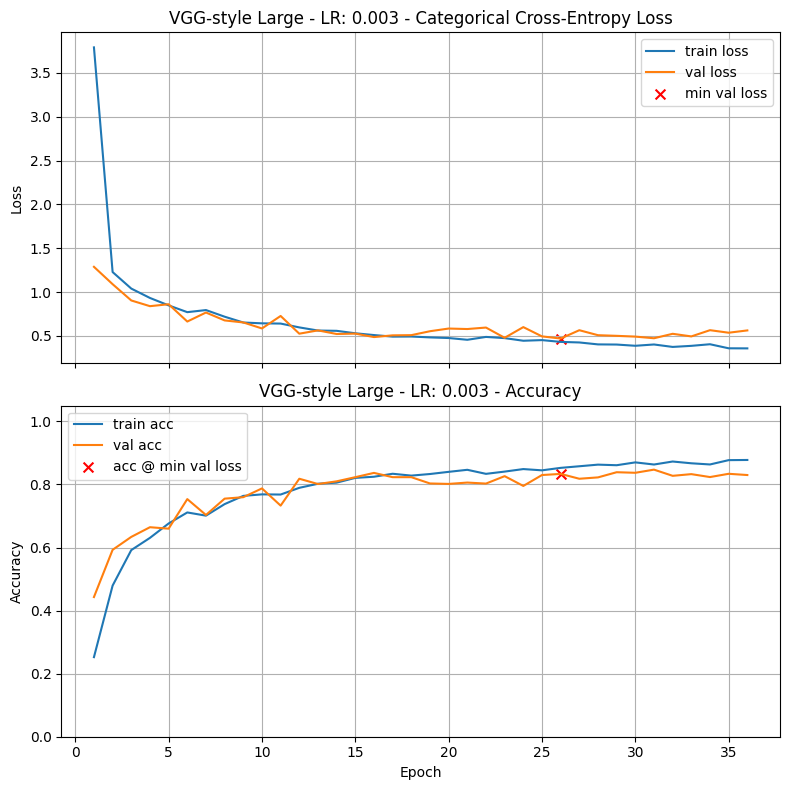

Final Training Loss:            0.3585
Final Training Accuracy:        0.8776
Final Validation Loss:          0.5634
Final Validation Accuracy:      0.8299
Minimum Validation Loss:        0.4709 (Epoch 26)
Validation Accuracy @ Min Loss: 0.8335

Test Loss: 0.4815
Test Accuracy: 0.8320

Validation-Test Gap (accuracy): 0.001452

Execution Time: 00:06:08

VGG-style Large - LR: 0.001

Epoch 1/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.3621 - loss: 2.1190 - val_accuracy: 0.6822 - val_loss: 0.8410
Epoch 2/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.6281 - loss: 0.9403 - val_accuracy: 0.7368 - val_loss: 0.7222
Epoch 3/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7280 - loss: 0.7527 - val_accuracy: 0.7101 - val_loss: 0.7931
Epoch 4/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7651 - loss: 0.6463 - val_accuracy: 0.7871 - val_loss: 0.6151
Epoch 5/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8017 - loss: 0.5721 - v

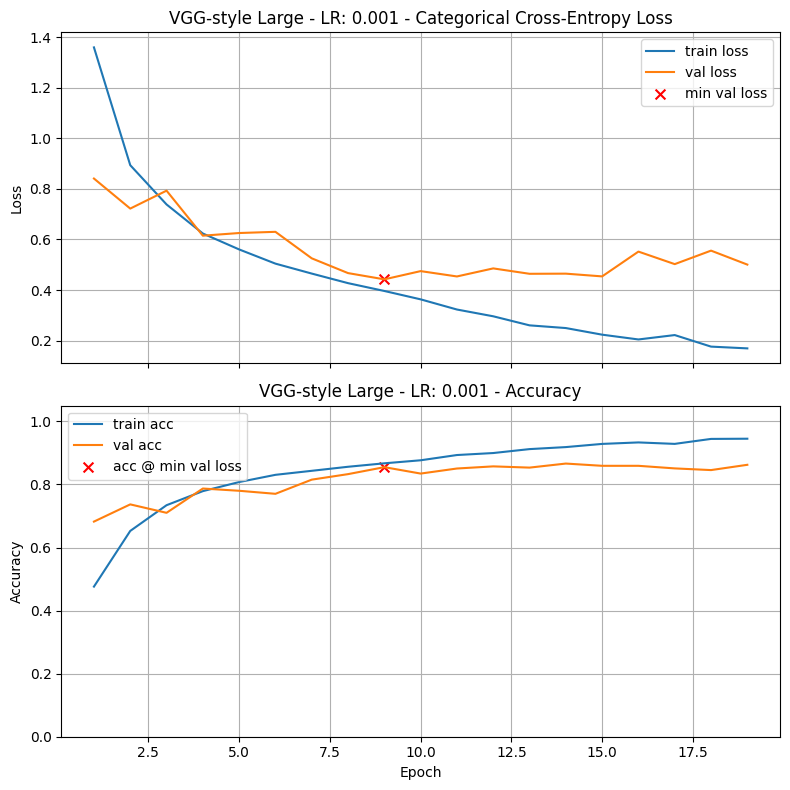

Final Training Loss:            0.1694
Final Training Accuracy:        0.9451
Final Validation Loss:          0.5007
Final Validation Accuracy:      0.8623
Minimum Validation Loss:        0.4424 (Epoch 9)
Validation Accuracy @ Min Loss: 0.8549

Test Loss: 0.4566
Test Accuracy: 0.8490

Validation-Test Gap (accuracy): 0.005850

Execution Time: 00:03:21

VGG-style Large - LR: 0.0003

Epoch 1/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.3758 - loss: 1.4880 - val_accuracy: 0.6316 - val_loss: 0.9812
Epoch 2/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6437 - loss: 0.9285 - val_accuracy: 0.6997 - val_loss: 0.8030
Epoch 3/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7218 - loss: 0.7718 - val_accuracy: 0.7628 - val_loss: 0.6664
Epoch 4/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7863 - loss: 0.6208 - val_accuracy: 0.8060 - val_loss: 0.5843
Epoch 5/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8112 - loss: 0.5463 - va

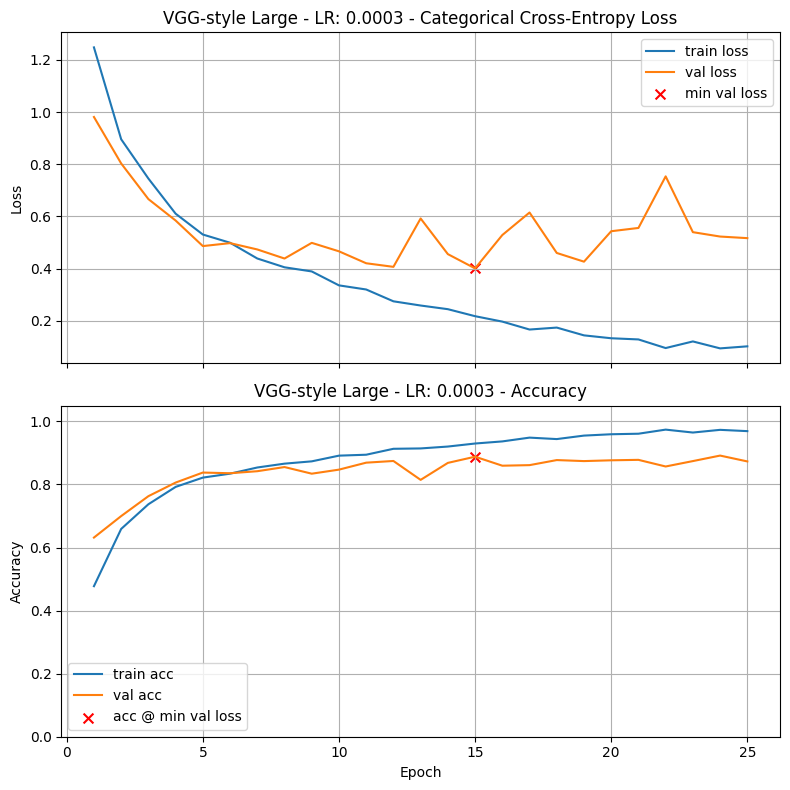

Final Training Loss:            0.1020
Final Training Accuracy:        0.9691
Final Validation Loss:          0.5168
Final Validation Accuracy:      0.8730
Minimum Validation Loss:        0.4008 (Epoch 15)
Validation Accuracy @ Min Loss: 0.8880

Test Loss: 0.4045
Test Accuracy: 0.8873

Validation-Test Gap (accuracy): 0.000684

Execution Time: 00:04:13

VGG-style Large - LR: 0.0001

Epoch 1/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.4433 - loss: 1.3790 - val_accuracy: 0.6947 - val_loss: 0.8880
Epoch 2/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6951 - loss: 0.8667 - val_accuracy: 0.7664 - val_loss: 0.6610
Epoch 3/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7741 - loss: 0.6834 - val_accuracy: 0.7935 - val_loss: 0.5878
Epoch 4/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7948 - loss: 0.6086 - val_accuracy: 0.8474 - val_loss: 0.4840
Epoch 5/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8373 - loss: 0.5060 - 

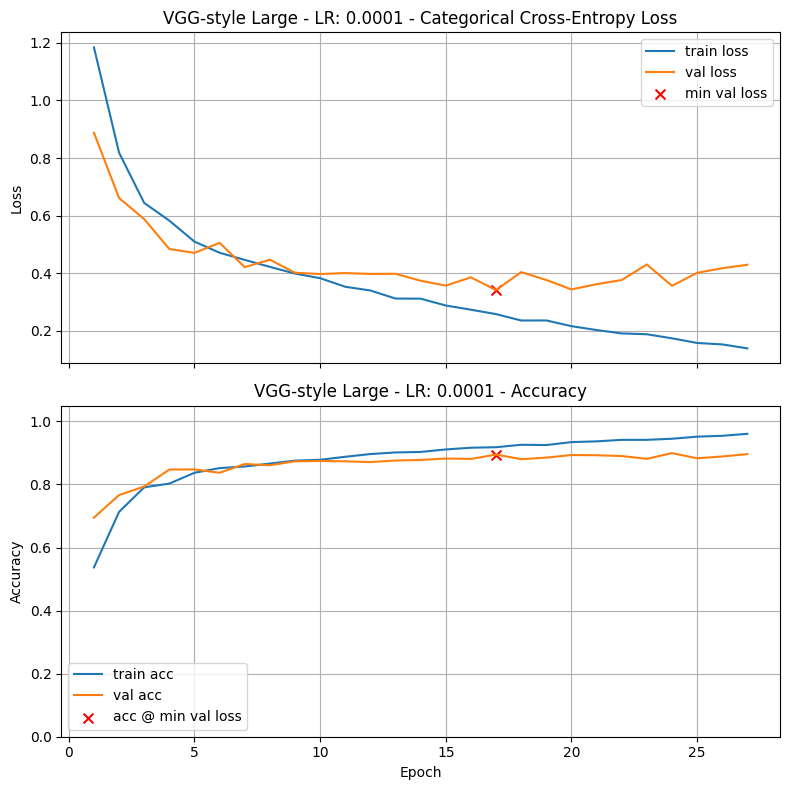

Final Training Loss:            0.1388
Final Training Accuracy:        0.9606
Final Validation Loss:          0.4293
Final Validation Accuracy:      0.8962
Minimum Validation Loss:        0.3412 (Epoch 17)
Validation Accuracy @ Min Loss: 0.8948

Test Loss: 0.3440
Test Accuracy: 0.8943

Validation-Test Gap (accuracy): 0.000460

Execution Time: 00:04:34

VGG-style Large - LR: 3e-05

Epoch 1/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.3887 - loss: 1.4905 - val_accuracy: 0.6209 - val_loss: 1.0009
Epoch 2/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6164 - loss: 1.0140 - val_accuracy: 0.6890 - val_loss: 0.8297
Epoch 3/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7000 - loss: 0.8461 - val_accuracy: 0.7175 - val_loss: 0.8110
Epoch 4/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7373 - loss: 0.7413 - val_accuracy: 0.7600 - val_loss: 0.6999
Epoch 5/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7667 - loss: 0.6761 - val

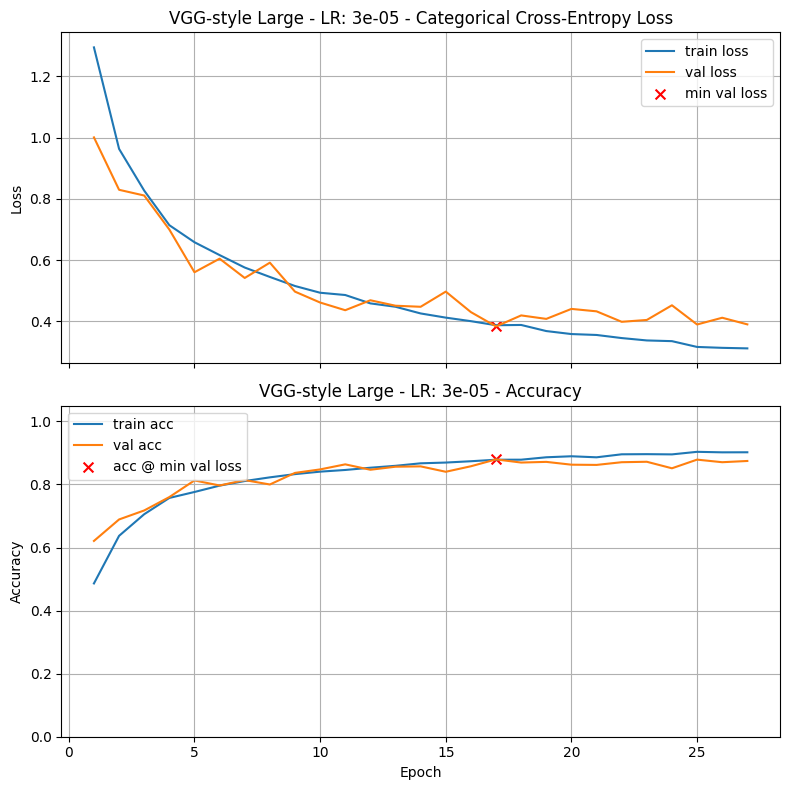

Final Training Loss:            0.3119
Final Training Accuracy:        0.9020
Final Validation Loss:          0.3903
Final Validation Accuracy:      0.8745
Minimum Validation Loss:        0.3836 (Epoch 17)
Validation Accuracy @ Min Loss: 0.8795

Test Loss: 0.3954
Test Accuracy: 0.8760

Validation-Test Gap (accuracy): 0.003458

Execution Time: 00:04:32

VGG-style Large - LR: 1e-05

Epoch 1/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.3273 - loss: 1.6546 - val_accuracy: 0.6077 - val_loss: 1.0668
Epoch 2/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5834 - loss: 1.0915 - val_accuracy: 0.6715 - val_loss: 0.9222
Epoch 3/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6426 - loss: 0.9593 - val_accuracy: 0.7254 - val_loss: 0.8103
Epoch 4/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6756 - loss: 0.9213 - val_accuracy: 0.7115 - val_loss: 0.8049
Epoch 5/500
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7142 - loss: 0.8113 - val

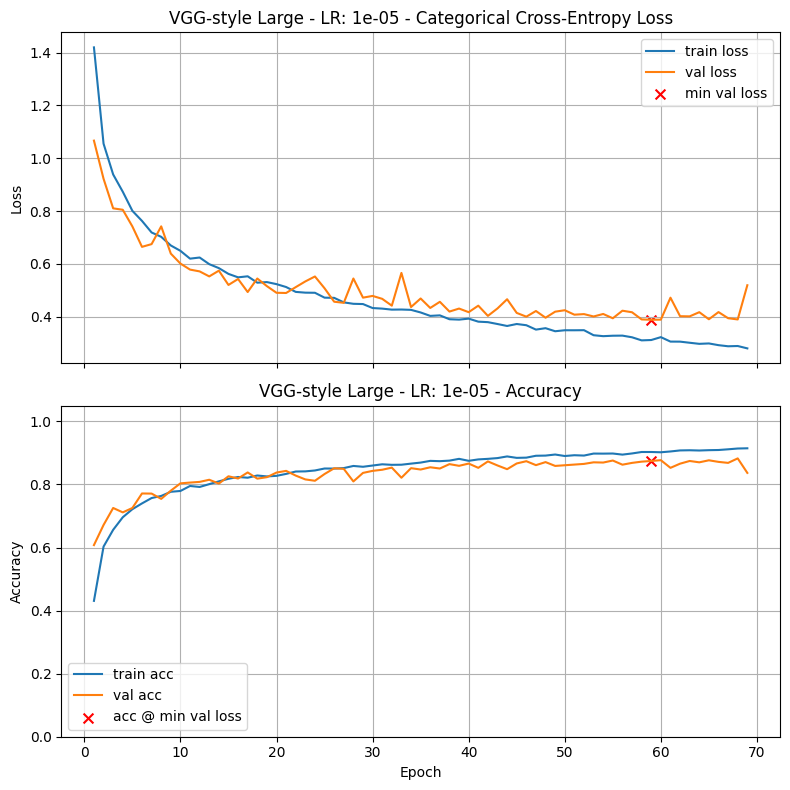

Final Training Loss:            0.2798
Final Training Accuracy:        0.9147
Final Validation Loss:          0.5190
Final Validation Accuracy:      0.8367
Minimum Validation Loss:        0.3882 (Epoch 59)
Validation Accuracy @ Min Loss: 0.8745

Test Loss: 0.3918
Test Accuracy: 0.8777

Validation-Test Gap (accuracy): 0.003202

Execution Time: 00:11:02


In [9]:
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)   # set to None to disable or tweak the value

model_vgg_16 = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Block 1
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.MaxPooling2D(),

    # Block 4 (NO MaxPool here -> leaves 3×3×512)
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),
    layers.Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer=he),

    # Global pooling meaningfully summarizes the 3×3 map
    layers.GlobalAveragePooling2D(),   # swap to GlobalMaxPooling2D() to compare

    # Compact head
    layers.Dense(256, activation='relu', kernel_initializer=he,
                 kernel_regularizer=l2reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Uncomment the next line to run
learning_rates = [1e-2, 3e-3, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]

for lr in learning_rates:
    tf.keras.backend.clear_session()  # clear session to reset layer names and avoid clutter
    model = models.clone_model(model_vgg_16)  # clone to reset weights for each run
    train_and_test(model, lr_schedule=lr, title=f"VGG-style Large - LR: {lr}", verbose=1)


### Graded Questions

In [12]:
# Set a5a to the learning rate which gave the best validation accuracy at the point of minimum validation loss

a5a = 0.0001             # Replace with your best learning rate

In [13]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.8f}')

a5a = 0.00010000


In [10]:
# Set a5b to the validation accuracy found by the choice specified in Question a5a (your best model for this problem)

a5b = 0.8948              # Replace 0.0 with your answer

In [11]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.8948


## All Results

This will print out the results from all experiments, with titles as keys. I use this all the time to keep track of experiments!

In [ ]:
print_results()

VGG-style Large - LR: 0.01              	0.1790	82
VGG-style Large - LR: 0.003             	0.1790	2
VGG-style Large - LR: 0.001             	0.1790	10
VGG-style Large - LR: 0.0003            	0.1790	3
VGG-style Large - LR: 0.0001            	0.1790	10
VGG-style Large - LR: 3e-05             	0.1790	6
VGG-style Large - LR: 1e-05             	0.1790	11


    VGG-style Large -- lr: 0.0001           	0.8700	18
    Model with ReduceLROnPlateau            	0.8636	227
    VGG-style Large -- lr: 0.0003           	0.8400	23
    VGG-style Large -- lr: 1e-05            	0.8301	60
    VGG-style Large -- lr: 3e-05            	0.8269	26
    Baseline model using BatchNormalization -- Tweak 2 -- 64 -> 128	0.8140	33
    Baseline Plus -- Tweaks 5 & 6 -- Do: 0.3	0.8030	50
    Baseline model using BatchNormalization -- Tweak 3 -- 32 -> 64 -> 128	0.8019	26
    Baseline model using BatchNormalization -- Tweak 4 -- Dense 128	0.7976	24
    Baseline model using BatchNormalization 	0.7941	7
    Baseline Plus -- Tweak 3 -- 32 -> 64 -> 128	0.7912	20
    Baseline Plus -- Tweak 6 -- Do: 0.3     	0.7745	36
    Baseline Plus -- Tweak 2 -- 64 -> 128   	0.7645	25
    Baseline Plus -- Tweak 5 -- L2: 1e-4    	0.7570	27
    Model using GAP                         	0.7553	10
    Baseline Plus -- Two Tweaks! -- L2: 1e-4 Do: 0.3	0.7506	19
    VGG-style Large -- lr: 0.001            	0.6865	5
    Baseline Plus -- Tweak 4 -- Dense 128   	0.5999	1
    Baseline Plus -- Tweak 1 -- lr: 1e-4    	0.4817	3
    Baseline model using BatchNormalization -- Tweak 1 lr: 0.0001 	0.3691	1
    VGG-style Large -- lr: 0.01             	0.1792	95
    VGG-style Large -- lr: 0.003            	0.1792	195
    Baseline Model                          	0.0000	1